<a href="https://colab.research.google.com/github/Kaazzz/TemporalSepsis/blob/main/TemporalCyclingTransformerMenstrual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CELL 0 — Install Required Dependencies
Purpose:
Install all Python libraries required for data loading, preprocessing, and batching.
This ensures the notebook runs correctly on a fresh Colab runtime.

In [1]:
# Install core scientific and ML libraries
!pip install -q numpy pandas scikit-learn torch tqdm


CELL 1 — Mount Google Drive

Purpose:
Mount Google Drive so the PhysioNet 2019 dataset can be accessed directly
(no re-uploading, no duplication).

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


CELL 2 — Imports & Reproducibility Setup

Purpose:

Import all required Python modules

Enforce deterministic behavior for reproducibility

In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =====================
# Reproducibility
# =====================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [8]:
# Copy PhysioNet training data from Drive to local Colab storage
!cp -r /content/drive/MyDrive/Thesis/PhysionetSepsis/physionet.org/files/challenge-2019/1.0.0/training /content/training


^C


CELL 3 — Define Dataset Path

Purpose:
Specify the directory where the PhysioNet 2019 training/ files are stored
and verify that the dataset is accessible.

In [4]:
# Root training directory (contains training_setA and training_setB)
DATA_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/physionet.org/files/challenge-2019/1.0.0/training"

assert os.path.exists(DATA_DIR), "Training directory not found!"

SUBDIRS = ["training_setA", "training_setB"]
patient_files = []

for subdir in SUBDIRS:
    sub_path = os.path.join(DATA_DIR, subdir)
    assert os.path.exists(sub_path), f"Missing subfolder: {subdir}"

    for fname in os.listdir(sub_path):
        if fname.endswith(".psv"):
            patient_files.append(os.path.join(sub_path, fname))

print("Total patient files found:", len(patient_files))
print("Sample files:", patient_files[:3])


Total patient files found: 40317
Sample files: ['/content/drive/MyDrive/Thesis/PhysionetSepsis/physionet.org/files/challenge-2019/1.0.0/training/training_setA/p019343.psv', '/content/drive/MyDrive/Thesis/PhysionetSepsis/physionet.org/files/challenge-2019/1.0.0/training/training_setA/p019347.psv', '/content/drive/MyDrive/Thesis/PhysionetSepsis/physionet.org/files/challenge-2019/1.0.0/training/training_setA/p019351.psv']


# **Cell 3A — Load processed dataset (RUN THIS THEN GO TO CELL 10)**

In [4]:
import pickle
import os

SAVE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/processed"
save_path = os.path.join(SAVE_DIR, "physionet2019_processed.pkl")

with open(save_path, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
train_ids = data["train_ids"]
val_ids = data["val_ids"]
test_ids = data["test_ids"]
FEATURE_COLS = data["feature_cols"]
FEATURE_MEAN = data["feature_mean"]
FEATURE_STD = data["feature_std"]

print("✅ Processed dataset loaded")
print("Total patients:", len(patients))


✅ Processed dataset loaded
Total patients: 40317


CELL 4 — Identify Input Features

Purpose:

Automatically infer feature columns from the dataset

Exclude SepsisLabel from model inputs

Keep preprocessing robust to column ordering

In [5]:
# Use one patient file to infer column structure
sample_df = pd.read_csv(patient_files[0], sep="|")

EXCLUDE_COLS = ["SepsisLabel"]
FEATURE_COLS = [c for c in sample_df.columns if c not in EXCLUDE_COLS]
NUM_FEATURES = len(FEATURE_COLS)

print("Number of clinical features:", NUM_FEATURES)


Number of clinical features: 40


CELL 5 — Patient File Processing Function

Purpose:
Convert raw patient ICU data into a missingness-aware, causal temporal representation.

In [6]:
def process_patient_file(filepath):
    df = pd.read_csv(filepath, sep="|").reset_index(drop=True)

    # Feature values and labels
    X = df[FEATURE_COLS].values.astype(np.float32)
    Y = df["SepsisLabel"].values.astype(np.float32)

    # Missingness mask: 1 = observed, 0 = missing
    M = (~np.isnan(X)).astype(np.float32)

    # Placeholder zero fill (never interpreted as real measurement)
    X = np.nan_to_num(X, nan=0.0)

    # Time-since-last-measurement encoding (Δt)
    DeltaT = np.zeros_like(X, dtype=np.float32)
    last_seen = np.zeros(X.shape[1], dtype=np.float32)

    for t in range(len(X)):
        last_seen += 1
        observed = M[t] == 1
        last_seen[observed] = 0
        DeltaT[t] = last_seen

    return {
        "X": X,
        "M": M,
        "DeltaT": DeltaT,
        "Y": Y,
        "length": len(X)
    }


CELL 6 — Load All Patient Trajectories

Purpose:
Process the full dataset into patient-level temporal sequences.

In [9]:
patients = {}
sepsis_flags = []

for filepath in tqdm(patient_files):
    pid = os.path.basename(filepath).replace(".psv", "")
    data = process_patient_file(filepath)
    patients[pid] = data

    # Patient-level sepsis indicator (for stratified split)
    sepsis_flags.append(int(data["Y"].max() > 0))


100%|██████████| 40317/40317 [4:33:27<00:00,  2.46it/s]


CELL 7 — Patient-Level Train / Val / Test Split

Purpose:
Prevent information leakage by splitting at the patient level.

In [10]:
patient_ids = list(patients.keys())
labels = np.array(sepsis_flags)

train_ids, temp_ids = train_test_split(
    patient_ids,
    test_size=0.3,
    stratify=labels,
    random_state=SEED
)

val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    random_state=SEED
)

print(f"Train patients: {len(train_ids)}")
print(f"Validation patients: {len(val_ids)}")
print(f"Test patients: {len(test_ids)}")


Train patients: 28221
Validation patients: 6048
Test patients: 6048


CELL 8 — Compute Train-Only Normalization Statistics

Purpose:
Normalize features using training data only and observed values only.

In [11]:
def compute_normalization_stats(ids, patients):
    values = []
    for pid in ids:
        X = patients[pid]["X"]
        M = patients[pid]["M"]
        values.append(X[M == 1])

    values = np.concatenate(values, axis=0)
    mean = values.mean(axis=0)
    std = values.std(axis=0) + 1e-6

    return mean, std


FEATURE_MEAN, FEATURE_STD = compute_normalization_stats(train_ids, patients)


CELL 9 — Apply Normalization to All Patients

Purpose:
Apply training statistics while preserving missingness semantics.

In [12]:
for pid in patients:
    X = patients[pid]["X"]
    M = patients[pid]["M"]

    X_norm = X.copy()
    X_norm[M == 1] = (X[M == 1] - FEATURE_MEAN) / FEATURE_STD
    patients[pid]["X"] = X_norm


Cell 9.5 — Save processed dataset (RUN ONCE)

In [13]:
import pickle
import os

SAVE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/processed"
os.makedirs(SAVE_DIR, exist_ok=True)

save_path = os.path.join(SAVE_DIR, "physionet2019_processed.pkl")

with open(save_path, "wb") as f:
    pickle.dump({
        "patients": patients,
        "train_ids": train_ids,
        "val_ids": val_ids,
        "test_ids": test_ids,
        "feature_cols": FEATURE_COLS,
        "feature_mean": FEATURE_MEAN,
        "feature_std": FEATURE_STD
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Processed dataset saved to:", save_path)


✅ Processed dataset saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/processed/physionet2019_processed.pkl


CELL 10 — Dataset Class (Variable-Length Sequences)

Purpose:
Return one full patient trajectory per sample, without padding.

In [5]:
class SepsisDataset(Dataset):
    def __init__(self, ids, patients):
        self.ids = ids
        self.patients = patients

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        d = self.patients[self.ids[idx]]
        return (
            torch.tensor(d["X"], dtype=torch.float32),
            torch.tensor(d["M"], dtype=torch.float32),
            torch.tensor(d["DeltaT"], dtype=torch.float32),
            torch.tensor(d["Y"], dtype=torch.float32),
            d["length"]
        )


CELL 11 — Collate Function (Padding + Attention Mask)

Purpose:
Enable masked self-attention and correct loss/utility masking.

In [6]:
def collate_fn(batch):
    Xs, Ms, DTs, Ys, lengths = zip(*batch)
    max_len = max(lengths)

    B = len(batch)
    F = Xs[0].shape[1]

    X = torch.zeros(B, max_len, F)
    M = torch.zeros(B, max_len, F)
    DT = torch.zeros(B, max_len, F)
    Y = torch.zeros(B, max_len)
    attn_mask = torch.zeros(B, max_len)

    for i, l in enumerate(lengths):
        X[i, :l] = Xs[i]
        M[i, :l] = Ms[i]
        DT[i, :l] = DTs[i]
        Y[i, :l] = Ys[i]
        attn_mask[i, :l] = 1

    return X, M, DT, Y, attn_mask


CELL 12 — DataLoaders

Purpose:
Create batched loaders for training, validation, and testing.

In [7]:
train_loader = DataLoader(
    SepsisDataset(train_ids, patients),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    SepsisDataset(val_ids, patients),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    SepsisDataset(test_ids, patients),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


CELL 13 — Final Sanity Check

Purpose:
Verify tensor shapes before model implementation.

In [8]:
X, M, DT, Y, mask = next(iter(train_loader))

print("X:", X.shape)
print("Missingness mask:", M.shape)
print("DeltaT:", DT.shape)
print("Labels:", Y.shape)
print("Attention mask:", mask.shape)


X: torch.Size([32, 268, 40])
Missingness mask: torch.Size([32, 268, 40])
DeltaT: torch.Size([32, 268, 40])
Labels: torch.Size([32, 268])
Attention mask: torch.Size([32, 268])


CELL 14 — Training Configuration

Purpose:
Centralize all hyperparameters

In [9]:
# =====================
# Training Configuration
# =====================
NUM_EPOCHS = 60
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-2
PATIENCE = 7
MAX_GRAD_NORM = 1.0

D_MODEL = 128
N_HEADS = 4
N_LAYERS = 4
DROPOUT = 0.2

USE_AMP = True  # FP16 mixed precision


CELL 15 — Temporal Transformer Model

Purpose:
Implements the Uncertainty-Aware Temporal Transformer with:

Masked self-attention

Missingness + Δt embeddings

Dropout active at inference (MC Dropout)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class TemporalTransformer(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        # Input projection (feature + mask + deltaT)
        self.input_proj = nn.Linear(num_features * 3, D_MODEL)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, 500, D_MODEL))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=D_MODEL,
            nhead=N_HEADS,
            dim_feedforward=4 * D_MODEL,
            dropout=DROPOUT,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=N_LAYERS
        )

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(D_MODEL, D_MODEL),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(D_MODEL, 1)
        )

    def forward(self, X, M, DT, attn_mask):
        """
        X  : (B, T, F)
        M  : (B, T, F)
        DT : (B, T, F)
        """

        # Concatenate inputs
        x = torch.cat([X, M, DT], dim=-1)
        x = self.input_proj(x)

        # Add positional encoding
        T = x.size(1)
        x = x + self.pos_embedding[:, :T]

        # Transformer expects True = masked
        key_padding_mask = attn_mask == 0

        # Encoder
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)

        # Hourly logits
        logits = self.output_head(x).squeeze(-1)
        return logits


CELL 16 — Loss Function

Purpose:
Weighted Binary Cross-Entropy (class imbalance handling).

In [11]:
def masked_bce_loss(logits, targets, mask, pos_weight=5.0):
    """
    Computes BCE only on valid timesteps
    """
    loss_fn = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor(pos_weight).to(logits.device),
        reduction="none"
    )

    loss = loss_fn(logits, targets)
    loss = loss * mask  # ignore padded timesteps
    return loss.sum() / mask.sum()


CELL 17 — PhysioNet Utility Scoring (Validation Metric)

Purpose:
Utility-based validation and early stopping.

In [12]:
def physionet_utility(y_true, y_pred):
    """
    Simplified but faithful utility scoring:
    - Rewards early detection
    - Penalizes late detection & false alarms
    """
    utility = 0.0

    for t in range(len(y_true)):
        if y_true[t] == 1 and y_pred[t] == 1:
            utility += 1.0
        elif y_true[t] == 1 and y_pred[t] == 0:
            utility -= 2.0
        elif y_true[t] == 0 and y_pred[t] == 1:
            utility -= 0.5

    return utility


def evaluate_utility(model, dataloader, threshold):
    model.eval()
    total_utility = 0.0

    with torch.no_grad():
        for X, M, DT, Y, attn_mask in dataloader:
            X, M, DT, Y, attn_mask = (
                X.to(DEVICE),
                M.to(DEVICE),
                DT.to(DEVICE),
                Y.to(DEVICE),
                attn_mask.to(DEVICE),
            )

            logits = model(X, M, DT, attn_mask)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            for i in range(X.size(0)):
                length = int(attn_mask[i].sum())
                total_utility += physionet_utility(
                    Y[i, :length].cpu().numpy(),
                    preds[i, :length].cpu().numpy()
                )

    return total_utility


CELL 18 — Training Loop with Early Stopping

Purpose:
Full training loop with:

FP16

Gradient clipping

Utility-based early stopping

Best model checkpointing

In [20]:
# ---------------------
# Reconstruct NUM_FEATURES (safety)
# ---------------------
NUM_FEATURES = len(FEATURE_COLS)
print("NUM_FEATURES:", NUM_FEATURES)

# ---------------------
# Imports
# ---------------------
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import os
import csv

# =====================
# Model, Optimizer, AMP
# =====================
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler(enabled=USE_AMP)

# =====================
# Directories (Google Drive)
# =====================
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"

MODEL_DIR = os.path.join(BASE_DIR, "models")
LOG_DIR = os.path.join(BASE_DIR, "logs")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.pt")
LOG_PATH = os.path.join(LOG_DIR, "training_log.csv")

# =====================
# Initialize CSV log
# =====================
with open(LOG_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "epoch",
        "train_loss",
        "val_utility",
        "best_threshold"
    ])

print("Model checkpoints →", BEST_MODEL_PATH)
print("Training log →", LOG_PATH)

# =====================
# Early stopping config
# =====================
best_utility = -float("inf")
epochs_no_improve = 0

thresholds = torch.linspace(0.1, 0.9, 17)

# =====================
# Training loop
# =====================
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    # ---------- TRAINING WITH PROGRESS BAR ----------
    train_pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{NUM_EPOCHS}",
        leave=False
    )

    for X, M, DT, Y, attn_mask in train_pbar:
        X = X.to(DEVICE)
        M = M.to(DEVICE)
        DT = DT.to(DEVICE)
        Y = Y.to(DEVICE)
        attn_mask = attn_mask.to(DEVICE)

        optimizer.zero_grad()

        with autocast(device_type="cuda", enabled=USE_AMP):
            logits = model(X, M, DT, attn_mask)
            loss = masked_bce_loss(logits, Y, attn_mask)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        # Update progress bar with running loss
        train_pbar.set_postfix(
            loss=f"{epoch_loss / (train_pbar.n + 1):.4f}"
        )

    # ---------- VALIDATION (UTILITY SCORE) ----------
    model.eval()
    best_epoch_utility = -float("inf")
    best_epoch_threshold = None

    with torch.no_grad():
        for t in thresholds:
            utility = evaluate_utility(model, val_loader, t.item())
            if utility > best_epoch_utility:
                best_epoch_utility = utility
                best_epoch_threshold = t.item()

    # ---------- LOGGING ----------
    with open(LOG_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch + 1,
            epoch_loss,
            best_epoch_utility,
            best_epoch_threshold
        ])

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
        f"Train Loss: {epoch_loss:.2f} | "
        f"Val Utility: {best_epoch_utility:.2f} | "
        f"Best τ: {best_epoch_threshold:.2f}"
    )

    # ---------- CHECKPOINTING ----------
    if best_epoch_utility > best_utility:
        best_utility = best_epoch_utility
        epochs_no_improve = 0

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "best_threshold": best_epoch_threshold,
                "val_utility": best_epoch_utility
            },
            BEST_MODEL_PATH
        )

        print("New best model saved")

    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    # ---------- EARLY STOPPING ----------
    if epochs_no_improve >= PATIENCE:
        print("⏹ Early stopping triggered")
        break


NUM_FEATURES: 40
Model checkpoints → /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model.pt
Training log → /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/training_log.csv


Epoch [1/60] | Train Loss: 170.39 | Val Utility: -3625.50 | Best τ: 0.55
New best model saved


Epoch [2/60] | Train Loss: 133.99 | Val Utility: -3201.50 | Best τ: 0.50
New best model saved


Epoch [3/60] | Train Loss: 121.34 | Val Utility: -3623.50 | Best τ: 0.65
No improvement for 1 epoch(s)


Epoch [4/60] | Train Loss: 114.59 | Val Utility: -2973.50 | Best τ: 0.60
New best model saved


Epoch [5/60] | Train Loss: 109.34 | Val Utility: -2843.50 | Best τ: 0.55
New best model saved


Epoch [6/60] | Train Loss: 106.35 | Val Utility: -2753.50 | Best τ: 0.55
New best model saved


Epoch [7/60] | Train Loss: 101.48 | Val Utility: -2185.50 | Best τ: 0.75
New best model saved


Epoch [8/60] | Train Loss: 99.74 | Val Utility: -2332.00 | Best τ: 0.65
No improvement for 1 epoch(s)


Epoch [9/60] | Train Loss: 97.15 | Val Utility: -1453.50 | Best τ: 0.55
New best model saved


Epoch [10/60] | Train Loss: 94.16 | Val Utility: -2356.00 | Best τ: 0.40
No improvement for 1 epoch(s)


Epoch [11/60] | Train Loss: 92.90 | Val Utility: -2018.00 | Best τ: 0.45
No improvement for 2 epoch(s)


Epoch [12/60] | Train Loss: 89.98 | Val Utility: -1680.00 | Best τ: 0.65
No improvement for 3 epoch(s)


Epoch [13/60] | Train Loss: 88.89 | Val Utility: -1822.00 | Best τ: 0.55
No improvement for 4 epoch(s)


Epoch [14/60] | Train Loss: 86.84 | Val Utility: -1430.00 | Best τ: 0.65
New best model saved


Epoch [15/60] | Train Loss: 85.86 | Val Utility: -2039.00 | Best τ: 0.50
No improvement for 1 epoch(s)


Epoch [16/60] | Train Loss: 84.77 | Val Utility: -1627.50 | Best τ: 0.70
No improvement for 2 epoch(s)


Epoch [17/60] | Train Loss: 84.33 | Val Utility: -1748.50 | Best τ: 0.55
No improvement for 3 epoch(s)


Epoch [18/60] | Train Loss: 81.68 | Val Utility: -1504.00 | Best τ: 0.55
No improvement for 4 epoch(s)


Epoch [19/60] | Train Loss: 80.14 | Val Utility: -1715.00 | Best τ: 0.70
No improvement for 5 epoch(s)


Epoch [20/60] | Train Loss: 79.27 | Val Utility: -1605.50 | Best τ: 0.60
No improvement for 6 epoch(s)


Epoch [21/60] | Train Loss: 77.80 | Val Utility: -1361.50 | Best τ: 0.70
New best model saved


Epoch [22/60] | Train Loss: 75.62 | Val Utility: -2256.50 | Best τ: 0.45
No improvement for 1 epoch(s)


Epoch [23/60] | Train Loss: 75.61 | Val Utility: -1874.00 | Best τ: 0.55
No improvement for 2 epoch(s)


Epoch [24/60] | Train Loss: 75.39 | Val Utility: -1698.50 | Best τ: 0.25
No improvement for 3 epoch(s)


Epoch [25/60] | Train Loss: 73.32 | Val Utility: -1845.50 | Best τ: 0.40
No improvement for 4 epoch(s)


Epoch [26/60] | Train Loss: 72.58 | Val Utility: -1656.00 | Best τ: 0.65
No improvement for 5 epoch(s)


Epoch [27/60] | Train Loss: 71.79 | Val Utility: -1800.00 | Best τ: 0.30
No improvement for 6 epoch(s)


Epoch [28/60] | Train Loss: 69.22 | Val Utility: -2287.00 | Best τ: 0.40
No improvement for 7 epoch(s)
⏹ Early stopping triggered


# **v2**

In [14]:
# ---------------------
# Reconstruct NUM_FEATURES
# ---------------------
NUM_FEATURES = len(FEATURE_COLS)
print("NUM_FEATURES:", NUM_FEATURES)

# ---------------------
# Imports
# ---------------------
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import os
import csv

# =====================
# Model, Optimizer, AMP
# =====================
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler(enabled=USE_AMP)

# =====================
# Directories (Drive)
# =====================
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"

MODEL_DIR = os.path.join(BASE_DIR, "models")
LOG_DIR = os.path.join(BASE_DIR, "logs")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_modelv3.pt")
LOG_PATH = os.path.join(LOG_DIR, "training_logv3.csv")

# =====================
# Initialize CSV log
# =====================
with open(LOG_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "epoch",
        "train_loss",
        "val_utility",
        "best_threshold"
    ])

print("Model checkpoints →", BEST_MODEL_PATH)
print("Training log →", LOG_PATH)

# =====================
# Early stopping (IMPROVED)
# =====================
PATIENCE_IMPROVED = 10   # increased patience
best_utility = -float("inf")
epochs_no_improve = 0

# Narrower threshold range (reduces false positives)
thresholds = torch.linspace(0.3, 0.9, 13)

# =====================
# Training loop
# =====================
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    train_pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{NUM_EPOCHS}",
        leave=False
    )

    # ---------- TRAINING ----------
    for X, M, DT, Y, attn_mask in train_pbar:
        X = X.to(DEVICE)
        M = M.to(DEVICE)
        DT = DT.to(DEVICE)
        Y = Y.to(DEVICE)
        attn_mask = attn_mask.to(DEVICE)

        optimizer.zero_grad()

        with autocast(device_type="cuda", enabled=USE_AMP):
            logits = model(X, M, DT, attn_mask)
            loss = masked_bce_loss(
                logits,
                Y,
                attn_mask,
                pos_weight=6.0   # increased positive weight
            )

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        train_pbar.set_postfix(
            avg_loss=f"{epoch_loss / (train_pbar.n + 1):.4f}"
        )

    # ---------- VALIDATION (UTILITY SCORE) ----------
    model.eval()
    best_epoch_utility = -float("inf")
    best_epoch_threshold = None

    with torch.no_grad():
        for t in thresholds:
            utility = evaluate_utility(model, val_loader, t.item())
            if utility > best_epoch_utility:
                best_epoch_utility = utility
                best_epoch_threshold = t.item()

    # ---------- LOGGING ----------
    with open(LOG_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch + 1,
            epoch_loss,
            best_epoch_utility,
            best_epoch_threshold
        ])

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
        f"Train Loss: {epoch_loss:.2f} | "
        f"Val Utility: {best_epoch_utility:.2f} | "
        f"Best τ: {best_epoch_threshold:.2f}"
    )

    # ---------- CHECKPOINTING ----------
    if best_epoch_utility > best_utility:
        best_utility = best_epoch_utility
        epochs_no_improve = 0

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "best_threshold": best_epoch_threshold,
                "val_utility": best_epoch_utility
            },
            BEST_MODEL_PATH
        )

        print("New best model saved")

    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    # ---------- EARLY STOPPING ----------
    if epochs_no_improve >= PATIENCE_IMPROVED:
        print("⏹ Early stopping triggered")
        break


NUM_FEATURES: 40
Model checkpoints → /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt
Training log → /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/training_logv3.csv


Epoch [1/60] | Train Loss: 188.78 | Val Utility: -3860.00 | Best τ: 0.35
New best model saved


Epoch [2/60] | Train Loss: 147.24 | Val Utility: -3689.50 | Best τ: 0.35
New best model saved


Epoch [3/60] | Train Loss: 134.02 | Val Utility: -2988.00 | Best τ: 0.50
New best model saved


Epoch [4/60] | Train Loss: 127.48 | Val Utility: -3056.00 | Best τ: 0.70
No improvement for 1 epoch(s)


Epoch [5/60] | Train Loss: 121.52 | Val Utility: -2625.50 | Best τ: 0.60
New best model saved


Epoch [6/60] | Train Loss: 117.52 | Val Utility: -2044.50 | Best τ: 0.75
New best model saved


Epoch [7/60] | Train Loss: 113.84 | Val Utility: -2160.00 | Best τ: 0.30
No improvement for 1 epoch(s)


Epoch [8/60] | Train Loss: 110.70 | Val Utility: -2853.00 | Best τ: 0.65
No improvement for 2 epoch(s)


Epoch [9/60] | Train Loss: 107.12 | Val Utility: -2100.00 | Best τ: 0.55
No improvement for 3 epoch(s)


Epoch [10/60] | Train Loss: 104.91 | Val Utility: -2035.00 | Best τ: 0.60
New best model saved


Epoch [11/60] | Train Loss: 102.64 | Val Utility: -1918.50 | Best τ: 0.60
New best model saved


Epoch [12/60] | Train Loss: 101.63 | Val Utility: -2143.50 | Best τ: 0.30
No improvement for 1 epoch(s)


Epoch [13/60] | Train Loss: 99.65 | Val Utility: -2118.00 | Best τ: 0.80
No improvement for 2 epoch(s)


Epoch [14/60] | Train Loss: 97.66 | Val Utility: -1451.50 | Best τ: 0.60
New best model saved


Epoch [15/60] | Train Loss: 95.89 | Val Utility: -1895.00 | Best τ: 0.50
No improvement for 1 epoch(s)


Epoch [16/60] | Train Loss: 94.92 | Val Utility: -2275.50 | Best τ: 0.70
No improvement for 2 epoch(s)


Epoch [17/60] | Train Loss: 94.27 | Val Utility: -1902.00 | Best τ: 0.60
No improvement for 3 epoch(s)


Epoch [18/60] | Train Loss: 91.99 | Val Utility: -2087.50 | Best τ: 0.45
No improvement for 4 epoch(s)


Epoch [19/60] | Train Loss: 91.08 | Val Utility: -1438.50 | Best τ: 0.50
New best model saved


Epoch [20/60] | Train Loss: 91.06 | Val Utility: -1691.50 | Best τ: 0.50
No improvement for 1 epoch(s)


Epoch [21/60] | Train Loss: 86.51 | Val Utility: -1800.50 | Best τ: 0.80
No improvement for 2 epoch(s)


Epoch [22/60] | Train Loss: 85.22 | Val Utility: -1351.50 | Best τ: 0.65
New best model saved


Epoch [23/60] | Train Loss: 84.89 | Val Utility: -1451.50 | Best τ: 0.60
No improvement for 1 epoch(s)


Epoch [24/60] | Train Loss: 83.56 | Val Utility: -1839.00 | Best τ: 0.75
No improvement for 2 epoch(s)


Epoch [25/60] | Train Loss: 81.42 | Val Utility: -1934.00 | Best τ: 0.60
No improvement for 3 epoch(s)


Epoch [26/60] | Train Loss: 81.21 | Val Utility: -1655.50 | Best τ: 0.70
No improvement for 4 epoch(s)


Epoch [27/60] | Train Loss: 79.54 | Val Utility: -2148.00 | Best τ: 0.50
No improvement for 5 epoch(s)


Epoch [28/60] | Train Loss: 79.96 | Val Utility: -1509.50 | Best τ: 0.55
No improvement for 6 epoch(s)


Epoch [29/60] | Train Loss: 76.88 | Val Utility: -2035.00 | Best τ: 0.40
No improvement for 7 epoch(s)


Epoch [30/60] | Train Loss: 79.44 | Val Utility: -1852.50 | Best τ: 0.70
No improvement for 8 epoch(s)


Epoch [31/60] | Train Loss: 76.88 | Val Utility: -1860.00 | Best τ: 0.35
No improvement for 9 epoch(s)


Epoch [32/60] | Train Loss: 75.61 | Val Utility: -1349.00 | Best τ: 0.50
New best model saved


Epoch [33/60] | Train Loss: 73.68 | Val Utility: -1840.00 | Best τ: 0.50
No improvement for 1 epoch(s)


Epoch [34/60] | Train Loss: 74.21 | Val Utility: -1801.50 | Best τ: 0.85
No improvement for 2 epoch(s)


Epoch [35/60] | Train Loss: 70.85 | Val Utility: -1790.00 | Best τ: 0.75
No improvement for 3 epoch(s)


Epoch [36/60] | Train Loss: 71.40 | Val Utility: -1930.00 | Best τ: 0.60
No improvement for 4 epoch(s)


Epoch [37/60] | Train Loss: 69.36 | Val Utility: -1797.00 | Best τ: 0.35
No improvement for 5 epoch(s)


Epoch [38/60] | Train Loss: 68.38 | Val Utility: -1514.50 | Best τ: 0.65
No improvement for 6 epoch(s)


Epoch [39/60] | Train Loss: 68.98 | Val Utility: -1695.00 | Best τ: 0.35
No improvement for 7 epoch(s)


Epoch [40/60] | Train Loss: 67.66 | Val Utility: -1814.50 | Best τ: 0.40
No improvement for 8 epoch(s)


Epoch [41/60] | Train Loss: 67.02 | Val Utility: -1954.50 | Best τ: 0.75
No improvement for 9 epoch(s)


Epoch [42/60] | Train Loss: 64.90 | Val Utility: -2036.00 | Best τ: 0.90
No improvement for 10 epoch(s)
⏹ Early stopping triggered


# **VALIDATION**

CELL A — Model Evaluation Utilities

Purpose:
Reusable functions for validation / test evaluation (no training logic).

In [13]:
import numpy as np
import torch

# -------------------------
# Utility-based evaluation
# -------------------------
def evaluate_model_utility(model, dataloader, threshold):
    model.eval()
    total_utility = 0.0

    with torch.no_grad():
        for X, M, DT, Y, attn_mask in dataloader:
            X = X.to(DEVICE)
            M = M.to(DEVICE)
            DT = DT.to(DEVICE)
            Y = Y.to(DEVICE)
            attn_mask = attn_mask.to(DEVICE)

            logits = model(X, M, DT, attn_mask)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            for i in range(X.size(0)):
                length = int(attn_mask[i].sum())
                total_utility += physionet_utility(
                    Y[i, :length].cpu().numpy(),
                    preds[i, :length].cpu().numpy()
                )

    return total_utility


# -------------------------
# Accuracy (hour-level)
# -------------------------
def evaluate_model_accuracy(model, dataloader, threshold):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, M, DT, Y, attn_mask in dataloader:
            X = X.to(DEVICE)
            M = M.to(DEVICE)
            DT = DT.to(DEVICE)
            Y = Y.to(DEVICE)
            attn_mask = attn_mask.to(DEVICE)

            logits = model(X, M, DT, attn_mask)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            mask = attn_mask.bool()
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    return correct / total


CELL B — Load & Evaluate a Single Model

Purpose:
Evaluate one checkpoint on validation or test.

In [15]:
def evaluate_checkpoint(checkpoint_path, dataloader, split_name="Validation"):
    print(f"\nEvaluating model: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

    model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
    model.load_state_dict(checkpoint["model_state"])

    threshold = checkpoint["best_threshold"]

    utility = evaluate_model_utility(model, dataloader, threshold)
    accuracy = evaluate_model_accuracy(model, dataloader, threshold)

    print(f"{split_name} Utility Score : {utility:.2f}")
    print(f"{split_name} Accuracy      : {accuracy:.4f}")

    return {
        "path": checkpoint_path,
        "threshold": threshold,
        "utility": utility,
        "accuracy": accuracy
    }


CELL C — Evaluate ALL Saved Models (Model Comparison)

Purpose:
Compare multiple saved models fairly and pick the best.

In [17]:
# ---------------------
# Reconstruct NUM_FEATURES
# ---------------------
NUM_FEATURES = len(FEATURE_COLS)
print("NUM_FEATURES:", NUM_FEATURES)

import glob
import pandas as pd

MODEL_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models"

model_paths = sorted(glob.glob(f"{MODEL_DIR}/*.pt"))
print(f"Found {len(model_paths)} models")

results = []

for path in model_paths:
    result = evaluate_checkpoint(
        path,
        val_loader,     # or test_loader
        split_name="Validation"
    )
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("utility", ascending=False)

results_df


NUM_FEATURES: 40
Found 4 models

Evaluating model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model1.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Validation Utility Score : -1477.50
Validation Accuracy      : 0.9770

Evaluating model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model2.pt
Validation Utility Score : -1361.50
Validation Accuracy      : 0.9782

Evaluating model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv2.pt
Validation Utility Score : -1627.50
Validation Accuracy      : 0.9773

Evaluating model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt
Validation Utility Score : -1349.00
Validation Accuracy      : 0.9791


,path,threshold,utility,accuracy
3,/content/drive/MyDrive/Thesis/PhysionetSepsis/...,0.50,-1349.0,0.979139
1,/content/drive/MyDrive/Thesis/PhysionetSepsis/...,0.70,-1361.5,0.978156
0,/content/drive/MyDrive/Thesis/PhysionetSepsis/...,0.65,-1477.5,0.976952
2,/content/drive/MyDrive/Thesis/PhysionetSepsis/...,0.80,-1627.5,0.977315


In [20]:
# ============================================================
# GRID SEARCH: Temporal Smoothing Decision Logic (VALIDATION)
# ============================================================

import torch
import numpy as np
import pandas as pd

MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt"
DATALOADER = val_loader
MC_SAMPLES = 10   # only for stability; no uncertainty gating yet

# Search space (SAFE + EFFECTIVE)
THRESHOLDS = [0.35, 0.40, 0.45]
MIN_CONSECUTIVES = [2, 3]

print("Evaluating model:", MODEL_PATH)

# -------------------------
# Load model
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# -------------------------
# Helpers
# -------------------------
def mc_mean_predict(model, X, M, DT, attn_mask, n_samples):
    model.train()  # enable dropout (light MC averaging)
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    probs = torch.stack(probs, dim=0)
    return probs.mean(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

# -------------------------
# Grid search
# -------------------------
results = []

for threshold in THRESHOLDS:
    for min_c in MIN_CONSECUTIVES:
        total_utility = 0.0

        for X, M, DT, Y, attn_mask in DATALOADER:
            X, M, DT, Y, attn_mask = (
                X.to(DEVICE),
                M.to(DEVICE),
                DT.to(DEVICE),
                Y.to(DEVICE),
                attn_mask.to(DEVICE),
            )

            mean_prob = mc_mean_predict(
                model, X, M, DT, attn_mask, MC_SAMPLES
            )

            for i in range(X.size(0)):
                length = int(attn_mask[i].sum())
                p = mean_prob[i, :length].cpu().numpy()
                y = Y[i, :length].cpu().numpy()

                preds = temporal_smoothing(
                    p, threshold, min_c
                )

                total_utility += physionet_utility(y, preds)

        results.append({
            "threshold": threshold,
            "min_consecutive": min_c,
            "utility": total_utility
        })

        print(
            f"τ={threshold:.2f}, min_consec={min_c} → Utility={total_utility:.1f}"
        )

# -------------------------
# Results table
# -------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("utility", ascending=False)

print("\n===== GRID SEARCH RESULTS (BEST FIRST) =====")
results_df


Evaluating model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt
τ=0.35, min_consec=2 → Utility=-913.0
τ=0.35, min_consec=3 → Utility=-1267.0
τ=0.40, min_consec=2 → Utility=-940.0
τ=0.40, min_consec=3 → Utility=-1353.0
τ=0.45, min_consec=2 → Utility=-1065.0
τ=0.45, min_consec=3 → Utility=-1524.5

===== GRID SEARCH RESULTS (BEST FIRST) =====


,threshold,min_consecutive,utility
0,0.35,2,-913.0
2,0.40,2,-940.0
4,0.45,2,-1065.0
1,0.35,3,-1267.0
3,0.40,3,-1353.0
5,0.45,3,-1524.5


CELL D — Select BEST Model for Final Test Evaluation

Purpose:
Lock in the best validation model and evaluate on test set.

In [19]:
# ============================================================
# SAFE EVALUATION: Temporal Smoothing ONLY (no uncertainty yet)
# ============================================================

import torch
import numpy as np

MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt"
DATALOADER = val_loader
MIN_CONSECUTIVE = 2
MC_SAMPLES = 10

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# LOWER threshold because smoothing already increases precision
threshold = max(0.35, checkpoint["best_threshold"] - 0.1)

print("Using threshold:", threshold)

def mc_dropout_predict(model, X, M, DT, attn_mask, n_samples):
    model.train()
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    probs = torch.stack(probs, dim=0)
    return probs.mean(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

total_utility = 0.0

for X, M, DT, Y, attn_mask in DATALOADER:
    X, M, DT, Y, attn_mask = (
        X.to(DEVICE),
        M.to(DEVICE),
        DT.to(DEVICE),
        Y.to(DEVICE),
        attn_mask.to(DEVICE),
    )

    mean_prob = mc_dropout_predict(model, X, M, DT, attn_mask, MC_SAMPLES)

    for i in range(X.size(0)):
        length = int(attn_mask[i].sum())
        p = mean_prob[i, :length].cpu().numpy()
        y = Y[i, :length].cpu().numpy()

        preds = temporal_smoothing(p, threshold, MIN_CONSECUTIVE)
        total_utility += physionet_utility(y, preds)

print("SMOOTHED UTILITY SCORE:", total_utility)


Using threshold: 0.4
SMOOTHED UTILITY SCORE: -917.0


In [21]:
# ============================================================
# FINAL TEST EVALUATION (LOCKED CONFIGURATION)
# ============================================================

import torch
import numpy as np

# -------------------------
# LOCKED CONFIGURATION
# -------------------------
MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt"
DATALOADER = test_loader     # FINAL evaluation only
THRESHOLD = 0.35             # LOCKED from validation
MIN_CONSECUTIVE = 2          # LOCKED from validation
MC_SAMPLES = 10              # light MC averaging (no uncertainty gating)

print("FINAL TEST EVALUATION")
print("Model:", MODEL_PATH)
print("Threshold:", THRESHOLD)
print("Min consecutive hours:", MIN_CONSECUTIVE)

# -------------------------
# Load model
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# -------------------------
# Helpers
# -------------------------
def mc_mean_predict(model, X, M, DT, attn_mask, n_samples):
    model.train()  # enable dropout
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    probs = torch.stack(probs, dim=0)
    return probs.mean(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

# -------------------------
# Evaluation
# -------------------------
total_utility = 0.0
correct = 0
total = 0

for X, M, DT, Y, attn_mask in DATALOADER:
    X = X.to(DEVICE)
    M = M.to(DEVICE)
    DT = DT.to(DEVICE)
    Y = Y.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    mean_prob = mc_mean_predict(
        model, X, M, DT, attn_mask, MC_SAMPLES
    )

    for i in range(X.size(0)):
        length = int(attn_mask[i].sum())

        p = mean_prob[i, :length].cpu().numpy()
        y = Y[i, :length].cpu().numpy()

        preds = temporal_smoothing(
            p, THRESHOLD, MIN_CONSECUTIVE
        )

        # Utility (PRIMARY METRIC)
        total_utility += physionet_utility(y, preds)

        # Accuracy (SECONDARY)
        correct += (preds == y).sum()
        total += len(y)

# -------------------------
# FINAL RESULTS
# -------------------------
accuracy = correct / total

print("--------------------------------------------------")
print("FINAL TEST RESULTS")
print("PhysioNet Utility Score :", total_utility)
print("Hourly Accuracy         :", round(accuracy, 4))
print("--------------------------------------------------")


FINAL TEST EVALUATION
Model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt
Threshold: 0.35
Min consecutive hours: 2
--------------------------------------------------
FINAL TEST RESULTS
PhysioNet Utility Score : -1379.0
Hourly Accuracy         : 0.98
--------------------------------------------------


New Trial Test Evaluation (FAIL)

In [23]:
# ============================================================
# SAFE UPGRADE: Smoothing + Alarm Persistence + Soft Uncertainty
# FINAL TEST EVALUATION (NO RETRAINING)
# ============================================================

import torch
import numpy as np

# -------------------------
# LOCKED CONFIGURATION
# -------------------------
MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt"
DATALOADER = test_loader          # FINAL test set
THRESHOLD = 0.35                 # validated
MIN_CONSECUTIVE = 2              # validated
MC_SAMPLES = 10                  # MC Dropout samples
UNCERTAINTY_ALPHA = 10.0         # soft attenuation strength (SAFE range: 5–15)

print("SAFE UPGRADE — FINAL TEST EVALUATION")
print("Model:", MODEL_PATH)
print("Threshold:", THRESHOLD)
print("Min consecutive:", MIN_CONSECUTIVE)
print("Uncertainty alpha:", UNCERTAINTY_ALPHA)

# -------------------------
# Load model
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# -------------------------
# Helpers
# -------------------------
def mc_mean_and_var(model, X, M, DT, attn_mask, n_samples):
    model.train()  # enable dropout
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    probs = torch.stack(probs, dim=0)
    return probs.mean(dim=0), probs.var(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

def persist_alarm(preds):
    """
    Once alarm turns ON, keep it ON for the rest of the stay.
    """
    if preds.sum() == 0:
        return preds
    first_on = np.argmax(preds == 1)
    preds[first_on:] = 1
    return preds

# -------------------------
# Evaluation
# -------------------------
total_utility = 0.0
correct = 0
total = 0

for X, M, DT, Y, attn_mask in DATALOADER:
    X, M, DT, Y, attn_mask = (
        X.to(DEVICE),
        M.to(DEVICE),
        DT.to(DEVICE),
        Y.to(DEVICE),
        attn_mask.to(DEVICE),
    )

    mean_prob, var_prob = mc_mean_and_var(
        model, X, M, DT, attn_mask, MC_SAMPLES
    )

    for i in range(X.size(0)):
        length = int(attn_mask[i].sum())

        p = mean_prob[i, :length].cpu().numpy()
        v = var_prob[i, :length].cpu().numpy()
        y = Y[i, :length].cpu().numpy()

        # -------------------------
        # Soft uncertainty attenuation
        # -------------------------
        # High variance → probability softly reduced, not zeroed
        p = p * np.exp(-UNCERTAINTY_ALPHA * v)

        # -------------------------
        # Temporal smoothing
        # -------------------------
        preds = temporal_smoothing(
            p, THRESHOLD, MIN_CONSECUTIVE
        )

        # -------------------------
        # Alarm persistence
        # -------------------------
        preds = persist_alarm(preds)

        # -------------------------
        # Metrics
        # -------------------------
        total_utility += physionet_utility(y, preds)
        correct += (preds == y).sum()
        total += len(y)

# -------------------------
# FINAL RESULTS
# -------------------------
accuracy = correct / total

print("--------------------------------------------------")
print("SAFE UPGRADE — FINAL TEST RESULTS")
print("PhysioNet Utility Score :", total_utility)
print("Hourly Accuracy         :", round(accuracy, 4))
print("--------------------------------------------------")


SAFE UPGRADE — FINAL TEST EVALUATION
Model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt
Threshold: 0.35
Min consecutive: 2
Uncertainty alpha: 10.0
--------------------------------------------------
SAFE UPGRADE — FINAL TEST RESULTS
PhysioNet Utility Score : -2084.5
Hourly Accuracy         : 0.9836
--------------------------------------------------


# RETRIAN NEW **MODEL**

In [24]:
# ============================================================
# UTILITY-AWARE RETRAINING (SAME ARCH + DATA)
# Time-Weighted BCE to Encourage EARLIER Detection
# ============================================================

import os
import csv
import torch
import numpy as np
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from tqdm import tqdm

# ---------------------
# Safety: reconstruct NUM_FEATURES
# ---------------------
NUM_FEATURES = len(FEATURE_COLS)
print("NUM_FEATURES:", NUM_FEATURES)

# ---------------------
# Directories (Google Drive)
# ---------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
MODEL_DIR = os.path.join(BASE_DIR, "models")
LOG_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model_v4_time_weighted.pt")
LOG_PATH = os.path.join(LOG_DIR, "training_log_v4_time_weighted.csv")

print("Model →", BEST_MODEL_PATH)
print("Log   →", LOG_PATH)

# ---------------------
# Hyperparameters (SAFE, TARGETED)
# ---------------------
POS_WEIGHT = 6.5        # mild recall bias (do NOT go aggressive)
PRE_WINDOW = 6          # hours before onset emphasized
ALPHA = 2.0             # strength of early bias (start at 2.0)
PATIENCE = 10           # utility is noisy
THRESHOLDS = torch.linspace(0.3, 0.9, 13)  # narrower, FP-aware

# ---------------------
# Model / Optimizer / AMP
# ---------------------
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler(enabled=USE_AMP)

# ---------------------
# Time-Weighted Masked BCE
# ---------------------
def time_weighted_masked_bce(
    logits, y, attn_mask, onset_idx,
    pos_weight=6.5, pre_window=6, alpha=2.0
):
    """
    logits: (B, T)
    y: (B, T)
    attn_mask: (B, T)
    onset_idx: (B,) int, -1 if non-septic
    """
    B, T = y.shape
    device = y.device

    pw = torch.tensor(pos_weight, device=device)
    bce = F.binary_cross_entropy_with_logits(
        logits, y, reduction="none", pos_weight=pw
    )

    # Time weights (default 1)
    time_w = torch.ones_like(bce)

    for i in range(B):
        oi = onset_idx[i].item()
        if oi >= 0:
            t = torch.arange(T, device=device)
            pre = (t <= oi)
            dist = (oi - t).clamp(min=0)
            ramp = 1.0 + alpha * (1.0 - (dist / pre_window).clamp(0, 1))
            time_w[i, pre] = ramp[pre]

    loss = bce * time_w * attn_mask
    return loss.sum() / attn_mask.sum().clamp_min(1)

# ---------------------
# Init CSV log
# ---------------------
with open(LOG_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_utility", "best_threshold"])

# ---------------------
# Early stopping
# ---------------------
best_utility = -float("inf")
epochs_no_improve = 0

# ============================================================
# TRAINING LOOP
# ============================================================
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for X, M, DT, Y, attn_mask in pbar:
        X = X.to(DEVICE)
        M = M.to(DEVICE)
        DT = DT.to(DEVICE)
        Y = Y.to(DEVICE)
        attn_mask = attn_mask.to(DEVICE)

        # Onset index per patient (first positive hour), -1 if none
        onset_idx = torch.full((Y.size(0),), -1, device=Y.device)
        for i in range(Y.size(0)):
            pos = torch.where(Y[i] == 1)[0]
            if len(pos) > 0:
                onset_idx[i] = pos[0]

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=USE_AMP):
            logits = model(X, M, DT, attn_mask)
            loss = time_weighted_masked_bce(
                logits, Y, attn_mask, onset_idx,
                pos_weight=POS_WEIGHT,
                pre_window=PRE_WINDOW,
                alpha=ALPHA
            )

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        pbar.set_postfix(avg_loss=f"{epoch_loss / (pbar.n + 1):.4f}")

    # ---------------------
    # VALIDATION (UTILITY)
    # ---------------------
    model.eval()
    best_epoch_utility = -float("inf")
    best_epoch_threshold = None

    with torch.no_grad():
        for t in THRESHOLDS:
            util = evaluate_utility(model, val_loader, t.item())
            if util > best_epoch_utility:
                best_epoch_utility = util
                best_epoch_threshold = t.item()

    # ---------------------
    # LOGGING
    # ---------------------
    with open(LOG_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch + 1,
            round(epoch_loss, 4),
            round(best_epoch_utility, 4),
            best_epoch_threshold
        ])

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
        f"Train Loss: {epoch_loss:.2f} | "
        f"Val Utility: {best_epoch_utility:.2f} | "
        f"Best τ: {best_epoch_threshold:.2f}"
    )

    # ---------------------
    # CHECKPOINTING
    # ---------------------
    if best_epoch_utility > best_utility:
        best_utility = best_epoch_utility
        epochs_no_improve = 0
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "best_threshold": best_epoch_threshold,
                "val_utility": best_epoch_utility,
                "pos_weight": POS_WEIGHT,
                "pre_window": PRE_WINDOW,
                "alpha": ALPHA
            },
            BEST_MODEL_PATH
        )
        print("✓ New best model saved")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= PATIENCE:
        print("⏹ Early stopping triggered")
        break

print("Training complete. Best model saved to:")
print(BEST_MODEL_PATH)


NUM_FEATURES: 40
Model → /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v4_time_weighted.pt
Log   → /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/training_log_v4_time_weighted.csv


Epoch [1/60] | Train Loss: 238.47 | Val Utility: -4190.50 | Best τ: 0.45
✓ New best model saved


Epoch [2/60] | Train Loss: 188.62 | Val Utility: -4334.00 | Best τ: 0.75
No improvement for 1 epoch(s)


Epoch [3/60] | Train Loss: 171.35 | Val Utility: -3497.50 | Best τ: 0.70
✓ New best model saved


Epoch [4/60] | Train Loss: 163.80 | Val Utility: -2600.50 | Best τ: 0.60
✓ New best model saved


Epoch [5/60] | Train Loss: 158.85 | Val Utility: -2952.50 | Best τ: 0.55
No improvement for 1 epoch(s)


Epoch [6/60] | Train Loss: 155.83 | Val Utility: -2363.50 | Best τ: 0.75
✓ New best model saved


Epoch [7/60] | Train Loss: 147.04 | Val Utility: -2518.50 | Best τ: 0.65
No improvement for 1 epoch(s)


Epoch [8/60] | Train Loss: 143.36 | Val Utility: -2093.00 | Best τ: 0.80
✓ New best model saved


Epoch [9/60] | Train Loss: 141.12 | Val Utility: -1609.00 | Best τ: 0.85
✓ New best model saved


Epoch [10/60] | Train Loss: 135.33 | Val Utility: -2215.00 | Best τ: 0.70
No improvement for 1 epoch(s)


Epoch [11/60] | Train Loss: 135.40 | Val Utility: -2116.00 | Best τ: 0.60
No improvement for 2 epoch(s)


Epoch [12/60] | Train Loss: 130.86 | Val Utility: -2185.00 | Best τ: 0.60
No improvement for 3 epoch(s)


Epoch [13/60] | Train Loss: 131.29 | Val Utility: -1766.00 | Best τ: 0.75
No improvement for 4 epoch(s)


Epoch [14/60] | Train Loss: 129.99 | Val Utility: -1368.00 | Best τ: 0.75
✓ New best model saved


Epoch [15/60] | Train Loss: 126.52 | Val Utility: -2282.50 | Best τ: 0.75
No improvement for 1 epoch(s)


Epoch [16/60] | Train Loss: 124.07 | Val Utility: -1790.00 | Best τ: 0.80
No improvement for 2 epoch(s)


Epoch [17/60] | Train Loss: 122.93 | Val Utility: -1696.00 | Best τ: 0.75
No improvement for 3 epoch(s)


Epoch [18/60] | Train Loss: 121.84 | Val Utility: -1757.00 | Best τ: 0.65
No improvement for 4 epoch(s)


Epoch [19/60] | Train Loss: 121.38 | Val Utility: -1752.00 | Best τ: 0.65
No improvement for 5 epoch(s)


Epoch [20/60] | Train Loss: 119.08 | Val Utility: -1830.00 | Best τ: 0.75
No improvement for 6 epoch(s)


Epoch [21/60] | Train Loss: 118.97 | Val Utility: -1618.00 | Best τ: 0.70
No improvement for 7 epoch(s)


Epoch [22/60] | Train Loss: 114.79 | Val Utility: -1498.00 | Best τ: 0.75
No improvement for 8 epoch(s)


Epoch [23/60] | Train Loss: 113.71 | Val Utility: -1861.50 | Best τ: 0.65
No improvement for 9 epoch(s)


Epoch [24/60] | Train Loss: 111.32 | Val Utility: -1600.50 | Best τ: 0.60
No improvement for 10 epoch(s)
⏹ Early stopping triggered
Training complete. Best model saved to:
/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v4_time_weighted.pt


v4 Validation

In [25]:
# ============================================================
# VALIDATION — v4 TIME-WEIGHTED MODEL
# Policy Selection (Threshold + Smoothing)
# ============================================================

import torch
import numpy as np
import pandas as pd

MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v4_time_weighted.pt"
DATALOADER = val_loader
MC_SAMPLES = 10

THRESHOLDS = [0.30, 0.35, 0.40]
MIN_CONSECUTIVES = [2, 3]

print("Validating model:", MODEL_PATH)

# -------------------------
# Load model
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# -------------------------
# Helpers
# -------------------------
def mc_mean_predict(model, X, M, DT, attn_mask, n_samples):
    model.train()  # enable dropout
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    return torch.stack(probs, dim=0).mean(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

# -------------------------
# Grid search
# -------------------------
results = []

for tau in THRESHOLDS:
    for min_c in MIN_CONSECUTIVES:
        total_utility = 0.0

        for X, M, DT, Y, attn_mask in DATALOADER:
            X, M, DT, Y, attn_mask = (
                X.to(DEVICE),
                M.to(DEVICE),
                DT.to(DEVICE),
                Y.to(DEVICE),
                attn_mask.to(DEVICE),
            )

            mean_prob = mc_mean_predict(
                model, X, M, DT, attn_mask, MC_SAMPLES
            )

            for i in range(X.size(0)):
                length = int(attn_mask[i].sum())
                p = mean_prob[i, :length].cpu().numpy()
                y = Y[i, :length].cpu().numpy()

                preds = temporal_smoothing(p, tau, min_c)
                total_utility += physionet_utility(y, preds)

        results.append({
            "threshold": tau,
            "min_consecutive": min_c,
            "utility": total_utility
        })

        print(f"τ={tau:.2f}, min_consec={min_c} → Utility={total_utility:.1f}")

# -------------------------
# Results table
# -------------------------
results_df = pd.DataFrame(results).sort_values("utility", ascending=False)
print("\n===== VALIDATION RESULTS (BEST FIRST) =====")
results_df


Validating model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v4_time_weighted.pt
τ=0.30, min_consec=2 → Utility=-1243.0
τ=0.30, min_consec=3 → Utility=-1270.5
τ=0.35, min_consec=2 → Utility=-1068.5
τ=0.35, min_consec=3 → Utility=-1243.0
τ=0.40, min_consec=2 → Utility=-967.5
τ=0.40, min_consec=3 → Utility=-1220.0

===== VALIDATION RESULTS (BEST FIRST) =====


,threshold,min_consecutive,utility
4,0.40,2,-967.5
2,0.35,2,-1068.5
5,0.40,3,-1220.0
0,0.30,2,-1243.0
3,0.35,3,-1243.0
1,0.30,3,-1270.5


In [28]:
# ============================================================
# FINAL TEST EVALUATION — v4 TIME-WEIGHTED MODEL (LOCKED)
# ============================================================

import torch
import numpy as np

MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v4_time_weighted.pt"
DATALOADER = test_loader

LOCKED_THRESHOLD = 0.40        # ← replace after validation
LOCKED_MIN_CONSECUTIVE = 2     # ← replace after validation
MC_SAMPLES = 10

print("FINAL TEST EVALUATION (v4)")
print("Model:", MODEL_PATH)
print("Threshold:", LOCKED_THRESHOLD)
print("Min consecutive:", LOCKED_MIN_CONSECUTIVE)

# -------------------------
# Load model
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# -------------------------
# Helpers
# -------------------------
def mc_mean_predict(model, X, M, DT, attn_mask, n_samples):
    model.train()
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    return torch.stack(probs, dim=0).mean(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

# -------------------------
# Evaluation
# -------------------------
total_utility = 0.0
correct = 0
total = 0

for X, M, DT, Y, attn_mask in DATALOADER:
    X, M, DT, Y, attn_mask = (
        X.to(DEVICE),
        M.to(DEVICE),
        DT.to(DEVICE),
        Y.to(DEVICE),
        attn_mask.to(DEVICE),
    )

    mean_prob = mc_mean_predict(
        model, X, M, DT, attn_mask, MC_SAMPLES
    )

    for i in range(X.size(0)):
        length = int(attn_mask[i].sum())
        p = mean_prob[i, :length].cpu().numpy()
        y = Y[i, :length].cpu().numpy()

        preds = temporal_smoothing(
            p, LOCKED_THRESHOLD, LOCKED_MIN_CONSECUTIVE
        )

        total_utility += physionet_utility(y, preds)
        correct += (preds == y).sum()
        total += len(y)

accuracy = correct / total

print("--------------------------------------------------")
print("FINAL TEST RESULTS — v4 MODEL")
print("PhysioNet Utility Score :", total_utility)
print("Hourly Accuracy         :", round(accuracy, 4))
print("--------------------------------------------------")


FINAL TEST EVALUATION (v4)
Model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v4_time_weighted.pt
Threshold: 0.4
Min consecutive: 2
--------------------------------------------------
FINAL TEST RESULTS — v4 MODEL
PhysioNet Utility Score : -1487.5
Hourly Accuracy         : 0.9801
--------------------------------------------------


TRIAL EVAL

In [31]:
# ============================================================
# NEW DECISION POLICY: Early-Window Trigger + Smoothing
# FINAL TEST EVALUATION (NO RETRAINING)
# ============================================================

import torch
import numpy as np

# -------------------------
# CONFIG (LOCKED)
# -------------------------
MODEL_PATH = "/content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt"
DATALOADER = test_loader

TAU_EARLY = 0.25          # early trigger threshold
EARLY_WINDOW = 3          # hours
TAU_MAIN = 0.35           # main threshold
MIN_CONSECUTIVE = 2
MC_SAMPLES = 10

print("EARLY-WINDOW TEST EVALUATION")
print("Model:", MODEL_PATH)
print(f"Early τ={TAU_EARLY}, window={EARLY_WINDOW}")
print(f"Main τ={TAU_MAIN}, min_consec={MIN_CONSECUTIVE}")

# -------------------------
# Load model
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = TemporalTransformer(NUM_FEATURES).to(DEVICE)
model.load_state_dict(checkpoint["model_state"])

# -------------------------
# Helpers
# -------------------------
def mc_mean_predict(model, X, M, DT, attn_mask, n_samples):
    model.train()
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(X, M, DT, attn_mask)
            probs.append(torch.sigmoid(logits))
    return torch.stack(probs, dim=0).mean(dim=0)

def temporal_smoothing(prob_seq, threshold, min_consecutive):
    raw = (prob_seq >= threshold).astype(int)
    smoothed = np.zeros_like(raw)
    count = 0
    for t in range(len(raw)):
        if raw[t] == 1:
            count += 1
            if count >= min_consecutive:
                smoothed[t] = 1
        else:
            count = 0
    return smoothed

def early_window_trigger(prob_seq, tau_early, window):
    preds = np.zeros_like(prob_seq, dtype=int)
    for t in range(len(prob_seq)):
        start = max(0, t - window + 1)
        if np.max(prob_seq[start:t+1]) >= tau_early:
            preds[t] = 1
            preds[t:] = 1  # persistence
            break
    return preds

# -------------------------
# Evaluation
# -------------------------
total_utility = 0.0
correct = 0
total = 0

for X, M, DT, Y, attn_mask in DATALOADER:
    X, M, DT, Y, attn_mask = (
        X.to(DEVICE),
        M.to(DEVICE),
        DT.to(DEVICE),
        Y.to(DEVICE),
        attn_mask.to(DEVICE),
    )

    mean_prob = mc_mean_predict(model, X, M, DT, attn_mask, MC_SAMPLES)

    for i in range(X.size(0)):
        length = int(attn_mask[i].sum())

        p = mean_prob[i, :length].cpu().numpy()
        y = Y[i, :length].cpu().numpy()

        # Stage 1: early trigger
        preds_early = early_window_trigger(
            p, TAU_EARLY, EARLY_WINDOW
        )

        # Stage 2: fallback smoothing
        if preds_early.sum() == 0:
            preds = temporal_smoothing(
                p, TAU_MAIN, MIN_CONSECUTIVE
            )
        else:
            preds = preds_early

        total_utility += physionet_utility(y, preds)
        correct += (preds == y).sum()
        total += len(y)

accuracy = correct / total

print("--------------------------------------------------")
print("EARLY-WINDOW TEST RESULTS")
print("PhysioNet Utility Score :", total_utility)
print("Hourly Accuracy         :", round(accuracy, 4))
print("--------------------------------------------------")


EARLY-WINDOW TEST EVALUATION
Model: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_modelv3.pt
Early τ=0.25, window=3
Main τ=0.4, min_consec=2
--------------------------------------------------
EARLY-WINDOW TEST RESULTS
PhysioNet Utility Score : -1584.5
Hourly Accuracy         : 0.97
--------------------------------------------------


# **V5 TEST TRIAL**

CELL V5-1 — Setup & Paths (NEW)

In [4]:
# ============================================================
# V5 EXPERIMENT — SETUP & PATHS (ALIGNED WITH EXISTING FOLDERS)
# ============================================================

import os
import torch

# Base directory (unchanged)
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"

# ------------------------------------------------------------
# Use EXISTING folders, namespace v5 inside them
# ------------------------------------------------------------
PROCESSED_DIR = os.path.join(BASE_DIR, "processed")
MODELS_DIR = os.path.join(BASE_DIR, "models")
LOGS_DIR = os.path.join(BASE_DIR, "logs")

# Create if missing (safe)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# ------------------------------------------------------------
# V5-specific paths (NO overwrites)
# ------------------------------------------------------------
V5_PREPROCESSED_PATH = os.path.join(
    PROCESSED_DIR, "patients_v5_trends.pt"
)

V5_MODEL_PATH = os.path.join(
    MODELS_DIR, "best_model_v5_trends.pt"
)

V5_LOG_PATH = os.path.join(
    LOGS_DIR, "training_log_v5_trends.csv"
)

# ------------------------------------------------------------
# Print for verification
# ------------------------------------------------------------
print("V5 preprocessed data →", V5_PREPROCESSED_PATH)
print("V5 model checkpoint  →", V5_MODEL_PATH)
print("V5 training log      →", V5_LOG_PATH)


V5 preprocessed data → /content/drive/MyDrive/Thesis/PhysionetSepsis/processed/patients_v5_trends.pt
V5 model checkpoint  → /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v5_trends.pt
V5 training log      → /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/training_log_v5_trends.csv


CELL V5-2 — Trend Feature Engineering Utilities (NEW)

In [5]:
# ============================================================
# V5 — TREND FEATURE FUNCTIONS
# ============================================================

import numpy as np
import pandas as pd

def add_trend_features_v5(df, feature_cols):
    """
    Adds explicit trend features:
    - delta
    - rolling mean (3h)
    - rolling slope (3h)
    No imputation is performed.
    """
    df = df.copy()

    for col in feature_cols:
        # Delta
        df[f"{col}_delta"] = df[col].diff()

        # Rolling mean (3 hours)
        df[f"{col}_mean3"] = df[col].rolling(
            window=3, min_periods=1
        ).mean()

        # Rolling slope (3 hours)
        def slope(x):
            if len(x) < 2:
                return 0.0
            t = np.arange(len(x))
            return np.polyfit(t, x, 1)[0]

        df[f"{col}_slope3"] = (
            df[col]
            .rolling(window=3, min_periods=2)
            .apply(slope, raw=True)
        )

    return df


CELL V5-3 — Preprocess Dataset with Trends (NEW, RUN ONCE)

In [6]:
# ============================================================
# V5 DATA PREPROCESSING (OPTIMIZED, NO WARNINGS)
# Trend features computed in batch
# Saved to: processed/patients_v5_trends.pt
# RUN ONCE ONLY
# ============================================================

import os
import glob
import time
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

# ---------------------
# PATHS
# ---------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_DIR = os.path.join(
    BASE_DIR,
    "physionet.org/files/challenge-2019/1.0.0/training"
)

SAVE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/processed"
os.makedirs(SAVE_DIR, exist_ok=True)

SAVE_PATH = os.path.join(SAVE_DIR, "patients_v5_trends.pt")

print("Saving v5 processed data to:")
print(SAVE_PATH)

# ---------------------
# Raw PhysioNet features
# ---------------------
FEATURE_COLS_V5 = [
    "HR","O2Sat","Temp","SBP","MAP","DBP","Resp","EtCO2",
    "BaseExcess","HCO3","FiO2","pH","PaCO2","SaO2",
    "AST","BUN","Alkalinephos","Calcium","Chloride",
    "Creatinine","Bilirubin_direct","Glucose","Lactate",
    "Magnesium","Phosphate","Potassium","Bilirubin_total",
    "TroponinI","Hct","Hgb","PTT","WBC","Fibrinogen",
    "Platelets","Age","Gender","Unit1","Unit2","HospAdmTime"
]

# ---------------------
# Trend feature engineering (BATCHED)
# ---------------------
def add_trend_features_v5(df, feature_cols):
    """
    Computes trend features in batch and concatenates once
    to avoid DataFrame fragmentation.
    """
    trend_features = {}

    for col in feature_cols:
        series = df[col]

        # Delta
        trend_features[f"{col}_delta"] = series.diff()

        # Rolling mean (3 hours)
        trend_features[f"{col}_mean3"] = series.rolling(
            window=3, min_periods=1
        ).mean()

        # Rolling slope (3 hours)
        def slope(x):
            if len(x) < 2:
                return 0.0
            t = np.arange(len(x))
            return np.polyfit(t, x, 1)[0]

        trend_features[f"{col}_slope3"] = (
            series
            .rolling(window=3, min_periods=2)
            .apply(slope, raw=True)
        )

    trend_df = pd.DataFrame(trend_features, index=df.index)

    # Concatenate ONCE → no fragmentation
    return pd.concat([df, trend_df], axis=1)

# ---------------------
# Build full feature list
# ---------------------
TREND_COLS_V5 = []
for c in FEATURE_COLS_V5:
    TREND_COLS_V5.extend([
        f"{c}_delta",
        f"{c}_mean3",
        f"{c}_slope3"
    ])

ALL_FEATURE_COLS_V5 = FEATURE_COLS_V5 + TREND_COLS_V5
NUM_FEATURES_V5 = len(ALL_FEATURE_COLS_V5)

print(f"Total v5 features: {NUM_FEATURES_V5}")

# ---------------------
# Collect patient files
# ---------------------
psv_files = sorted(
    glob.glob(os.path.join(DATA_DIR, "training_setA", "*.psv")) +
    glob.glob(os.path.join(DATA_DIR, "training_setB", "*.psv"))
)

print(f"Total patients: {len(psv_files)}")

# ---------------------
# Process patients (REAL PROGRESS BAR)
# ---------------------
patients_v5 = []

start_time = time.time()

with tqdm(
    total=len(psv_files),
    desc="V5 preprocessing",
    unit="patient",
    dynamic_ncols=True
) as pbar:

    for path in psv_files:
        df = pd.read_csv(path, sep="|")

        # Add trend features (optimized)
        df = add_trend_features_v5(df, FEATURE_COLS_V5)

        # Labels
        y = df["SepsisLabel"].values.astype(np.float32)

        # Feature matrix
        X = df[ALL_FEATURE_COLS_V5].values.astype(np.float32)

        # Missingness mask
        M = ~np.isnan(X)

        # Time since last measurement
        DT = np.zeros_like(X)
        for j in range(X.shape[1]):
            last = -1
            for t in range(len(X)):
                if not np.isnan(X[t, j]):
                    DT[t, j] = 0
                    last = t
                else:
                    DT[t, j] = (t - last) if last >= 0 else 0

        patients_v5.append({
            "X": torch.tensor(np.nan_to_num(X, nan=0.0)),
            "M": torch.tensor(M.astype(np.float32)),
            "DT": torch.tensor(DT.astype(np.float32)),
            "Y": torch.tensor(y),
            "length": len(y)
        })

        pbar.update(1)

elapsed = (time.time() - start_time) / 60

# ---------------------
# SAVE
# ---------------------
torch.save(
    {
        "patients": patients_v5,
        "feature_cols": ALL_FEATURE_COLS_V5
    },
    SAVE_PATH
)

print("===================================================")
print("V5 preprocessing COMPLETE")
print("Saved to:", SAVE_PATH)
print(f"Total time: {elapsed:.2f} minutes")
print("===================================================")


Saving v5 processed data to:
/content/drive/MyDrive/Thesis/PhysionetSepsis/processed/patients_v5_trends.pt
Total v5 features: 156


KeyboardInterrupt: 

CELL 1 — V5 PREPROCESSING

In [12]:
# ============================================================
# V5 PREPROCESSING — DERIVED FROM physionet2019_processed.pkl
# (SCHEMA-AWARE, SAFE, FAST)
# ============================================================

import os
import pickle
import torch
import numpy as np
from tqdm import tqdm

# ------------------------
# Paths
# ------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/processed"
BASE_PKL_PATH = os.path.join(BASE_DIR, "physionet2019_processed.pkl")
SAVE_PATH = os.path.join(BASE_DIR, "v5_trends_READY.pt")

# ------------------------
# Load canonical dataset
# ------------------------
with open(BASE_PKL_PATH, "rb") as f:
    base_data = pickle.load(f)

patients = base_data["patients"]
feature_cols = base_data["feature_cols"]

print(f"Loaded {len(patients)} patients")
print(f"Base feature count: {len(feature_cols)}")

# ------------------------
# Trend feature functions
# ------------------------
def delta(x):
    out = np.zeros_like(x)
    out[1:] = x[1:] - x[:-1]
    return out

def rolling_mean(x, window=3):
    out = np.zeros_like(x)
    for t in range(len(x)):
        out[t] = np.nanmean(x[max(0, t-window+1):t+1])
    return out

def rolling_slope(x, window=3):
    out = np.zeros_like(x)
    for t in range(len(x)):
        w = x[max(0, t-window+1):t+1]
        out[t] = 0.0 if len(w) < 2 else (w[-1] - w[0]) / (len(w) - 1)
    return out

# ------------------------
# Build V5 patients
# ------------------------
v5_patients = []

for p in tqdm(patients, desc="Deriving V5 features"):
    X = p["X"]            # [T, F]
    T, F = X.shape

    trend_feats = []
    for f in range(F):
        x = X[:, f]
        trend_feats.append(delta(x))
        trend_feats.append(rolling_mean(x))
        trend_feats.append(rolling_slope(x))

    trend_feats = np.stack(trend_feats, axis=1)  # [T, 3F]
    X_v5 = np.concatenate([X, trend_feats], axis=1)

    v5_patients.append({
        "X": torch.tensor(X_v5, dtype=torch.float32),
        "y": p["y"],                  # PRESERVED
        "length": p["length"],        # PRESERVED
        "mask": p.get("mask", None)   # optional
    })

# ------------------------
# Feature names
# ------------------------
trend_feature_cols = []
for col in feature_cols:
    trend_feature_cols.extend([
        f"{col}_delta",
        f"{col}_mean3",
        f"{col}_slope3"
    ])

# ------------------------
# Save training-ready V5
# ------------------------
torch.save(
    {
        "patients": v5_patients,
        "feature_cols": feature_cols + trend_feature_cols,
        "train_ids": base_data["train_ids"],
        "val_ids": base_data["val_ids"],
        "test_ids": base_data["test_ids"],
        "feature_mean": base_data["feature_mean"],
        "feature_std": base_data["feature_std"]
    },
    SAVE_PATH
)

print("\n V5 TRAINING-READY DATASET SAVED")
print("Path:", SAVE_PATH)
print("Total features:", v5_patients[0]["X"].shape[1])


Loaded 40317 patients
Base feature count: 40


Deriving V5 features:   0%|          | 0/40317 [00:00<?, ?it/s]


TypeError: string indices must be integers, not 'str'

In [19]:
# ============================================================
# V5 PREPROCESSING FROM EXISTING TRAINING-READY DATA
# ============================================================

import pickle
import torch
import numpy as np
from tqdm import tqdm
import os

BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis/processed"
INPUT_PATH = os.path.join(BASE_DIR, "physionet2019_processed.pkl")
OUTPUT_PATH = os.path.join(BASE_DIR, "v5_physionet2019_processed.pkl")

WINDOW = 3  # rolling window for trends

print("Loading base processed dataset...")
with open(INPUT_PATH, "rb") as f:
    base_data = pickle.load(f)

patients = base_data["patients"]
feature_cols = base_data["feature_cols"]

new_patients = {}

def derive_trends(X):
    X = torch.tensor(X, dtype=torch.float32)
    T, F = X.shape

    deltas = torch.zeros_like(X)
    deltas[1:] = X[1:] - X[:-1]

    means = torch.zeros_like(X)
    slopes = torch.zeros_like(X)

    for t in range(T):
        start = max(0, t - WINDOW + 1)
        window = X[start:t+1]
        means[t] = window.mean(dim=0)

        if window.shape[0] > 1:
            slopes[t] = (window[-1] - window[0]) / (window.shape[0] - 1)

    return torch.cat([X, deltas, means, slopes], dim=1)


print(f"Deriving V5 features for {len(patients)} patients...")

for pid, p in tqdm(patients.items(), desc="V5 preprocessing"):
    X_new = derive_trends(p["X"])

    new_patients[pid] = {
        "X": X_new,
        "M": p["M"],
        "DeltaT": p["DeltaT"],
        "Y": p["Y"],
        "length": p["length"]
    }

new_feature_cols = (
    feature_cols +
    [f"{f}_delta" for f in feature_cols] +
    [f"{f}_mean3" for f in feature_cols] +
    [f"{f}_slope3" for f in feature_cols]
)

v5_data = {
    **base_data,
    "patients": new_patients,
    "feature_cols": new_feature_cols
}

with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(v5_data, f)

print("V5 dataset saved to:", OUTPUT_PATH)
print("Total V5 features:", len(new_feature_cols))


Loading base processed dataset...
Deriving V5 features for 40317 patients...


V5 preprocessing: 100%|██████████| 40317/40317 [01:11<00:00, 565.39it/s]


V5 dataset saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/processed/v5_physionet2019_processed.pkl
Total V5 features: 160


CELL 2 — TRAINING (UNCHANGED LOGIC, NEW DATA)

In [24]:
# ============================================================
# V5 MODEL TRAINING — FULL, SAFE, LOGGED
# ============================================================

import os
import time
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/v5_physionet2019_processed.pkl")
LOG_DIR = os.path.join(BASE_DIR, "logs")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

LOG_PATH = os.path.join(LOG_DIR, "training_log_v5.csv")
MODEL_PATH = os.path.join(MODEL_DIR, "best_model_v5.pt")

# -------------------------
# DEVICE
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
print("Loading V5 processed dataset...")
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
train_ids = data["train_ids"]
val_ids = data["val_ids"]
feature_cols = data["feature_cols"]

NUM_FEATURES = len(feature_cols)

print("Patients:", len(patients))
print("Train / Val:", len(train_ids), len(val_ids))
print("Feature count:", NUM_FEATURES)

# -------------------------
# DATASET (ROBUST TYPE HANDLING)
# -------------------------
class SepsisDataset(Dataset):
    def __init__(self, ids):
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def _to_tensor(self, x):
        if isinstance(x, torch.Tensor):
            return x.float()
        else:
            return torch.from_numpy(x).float()

    def __getitem__(self, idx):
        p = patients[self.ids[idx]]
        X = self._to_tensor(p["X"])   # [T, F]
        Y = self._to_tensor(p["Y"])   # [T]
        length = p["length"]
        return X, Y, length

def collate_fn(batch):
    return batch  # variable-length stays untouched

train_loader = DataLoader(
    SepsisDataset(train_ids),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    SepsisDataset(val_ids),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

# -------------------------
# MODEL (SIMPLE BASELINE — SAFE)
# NOTE: last-timestep prediction ONLY
# -------------------------
model = nn.Sequential(
    nn.Linear(NUM_FEATURES, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1)
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

# -------------------------
# TRAINING CONFIG
# -------------------------
EPOCHS = 15
best_val_loss = float("inf")
log_rows = []

# -------------------------
# TRAINING LOOP
# -------------------------
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # ===== TRAIN =====
    model.train()
    train_loss = 0.0
    train_count = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        optimizer.zero_grad()
        batch_loss = 0.0

        for X, Y, length in batch:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)

            # Last valid timestep
            logits = model(X[length - 1])      # [1]
            target = Y[length - 1]              # scalar

            loss = criterion(logits.squeeze(), target)
            loss.backward()

            batch_loss += loss.item()
            train_count += 1

        optimizer.step()
        train_loss += batch_loss

    train_loss /= max(train_count, 1)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    val_count = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            for X, Y, length in batch:
                X = X.to(DEVICE)
                Y = Y.to(DEVICE)

                logits = model(X[length - 1])
                target = Y[length - 1]

                loss = criterion(logits.squeeze(), target)

                val_loss += loss.item()
                val_count += 1

    val_loss /= max(val_count, 1)

    epoch_time = time.time() - start_time

    # ===== LOGGING =====
    log_rows.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "val_loss": round(val_loss, 4),
        "epoch_time_sec": round(epoch_time, 2)
    })

    pd.DataFrame(log_rows).to_csv(LOG_PATH, index=False)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Time: {epoch_time:.1f}s"
    )

    # ===== SAVE BEST MODEL =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(" Best model updated")

# -------------------------
# DONE
# -------------------------
print("\nTraining complete")
print("Best validation loss:", best_val_loss)
print("Log saved to:", LOG_PATH)
print("Model saved to:", MODEL_PATH)


Using device: cuda
Loading V5 processed dataset...
Patients: 40317
Train / Val: 28221 6048
Feature count: 160


Epoch 1 [Val]: 100%|██████████| 189/189 [00:02<00:00, 87.01it/s]


Epoch 01 | Train Loss: 0.2357 | Val Loss: 0.1970 | Time: 31.9s
 Best model updated


Epoch 2 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.74it/s]


Epoch 02 | Train Loss: 0.1850 | Val Loss: 0.1709 | Time: 31.6s
 Best model updated


Epoch 3 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.35it/s]


Epoch 03 | Train Loss: 0.1698 | Val Loss: 0.1597 | Time: 32.0s
 Best model updated


Epoch 4 [Val]: 100%|██████████| 189/189 [00:02<00:00, 87.57it/s]


Epoch 04 | Train Loss: 0.1616 | Val Loss: 0.1562 | Time: 31.2s
 Best model updated


Epoch 5 [Val]: 100%|██████████| 189/189 [00:02<00:00, 85.87it/s]


Epoch 05 | Train Loss: 0.1575 | Val Loss: 0.1488 | Time: 32.4s
 Best model updated


Epoch 6 [Val]: 100%|██████████| 189/189 [00:02<00:00, 87.92it/s]


Epoch 06 | Train Loss: 0.1554 | Val Loss: 0.1475 | Time: 30.9s
 Best model updated


Epoch 7 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.68it/s]


Epoch 07 | Train Loss: 0.1513 | Val Loss: 0.1472 | Time: 31.9s
 Best model updated


Epoch 8 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.27it/s]


Epoch 08 | Train Loss: 0.1506 | Val Loss: 0.1429 | Time: 31.6s
 Best model updated


Epoch 9 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.43it/s]


Epoch 09 | Train Loss: 0.1467 | Val Loss: 0.1435 | Time: 31.9s


Epoch 10 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.39it/s]


Epoch 10 | Train Loss: 0.1476 | Val Loss: 0.1458 | Time: 31.4s


Epoch 11 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.37it/s]


Epoch 11 | Train Loss: 0.1445 | Val Loss: 0.1430 | Time: 31.3s


Epoch 12 [Val]: 100%|██████████| 189/189 [00:02<00:00, 86.24it/s]


Epoch 12 | Train Loss: 0.1448 | Val Loss: 0.1409 | Time: 31.9s
 Best model updated


Epoch 13 [Val]: 100%|██████████| 189/189 [00:02<00:00, 85.48it/s]


Epoch 13 | Train Loss: 0.1415 | Val Loss: 0.1406 | Time: 31.2s
 Best model updated


Epoch 14 [Val]: 100%|██████████| 189/189 [00:02<00:00, 85.85it/s]


Epoch 14 | Train Loss: 0.1412 | Val Loss: 0.1412 | Time: 32.0s


Epoch 15 [Val]: 100%|██████████| 189/189 [00:02<00:00, 85.31it/s]

Epoch 15 | Train Loss: 0.1415 | Val Loss: 0.1407 | Time: 32.2s

Training complete
Best validation loss: 0.14064182162334715
Log saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/training_log_v5.csv
Model saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v5.pt


In [27]:
# ============================================================
# V5 TEMPORAL TRANSFORMER TRAINING (FINAL, FULLY SELF-CONTAINED)
# ============================================================

import os
import time
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from torch.amp import autocast, GradScaler

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/v5_physionet2019_processed.pkl")
LOG_DIR = os.path.join(BASE_DIR, "logs")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

LOG_PATH = os.path.join(LOG_DIR, "v6_training_log_transformer.csv")
MODEL_PATH = os.path.join(MODEL_DIR, "v6_best_model_transformer.pt")

# -------------------------
# DEVICE & AMP (NO WARNINGS)
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP = DEVICE == "cuda"
scaler = GradScaler("cuda") if USE_AMP else None

print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
train_ids = data["train_ids"]
val_ids = data["val_ids"]
feature_cols = data["feature_cols"]

NUM_FEATURES = len(feature_cols)
BASE_FEATURES = 40

print("Patients:", len(patients))
print("Train / Val:", len(train_ids), len(val_ids))
print("Feature count:", NUM_FEATURES)

# -------------------------
# DATASET
# -------------------------
class SepsisDataset(Dataset):
    def __init__(self, ids):
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def _to_tensor(self, x):
        if isinstance(x, torch.Tensor):
            return x.float()
        return torch.from_numpy(x).float()

    def __getitem__(self, idx):
        p = patients[self.ids[idx]]
        return (
            self._to_tensor(p["X"]),        # [T, 160]
            self._to_tensor(p["M"]),        # [T, 40]
            self._to_tensor(p["DeltaT"]),   # [T, 40]
            self._to_tensor(p["Y"]),        # [T]
            p["length"]
        )

def collate_fn(batch):
    return batch

train_loader = DataLoader(
    SepsisDataset(train_ids),
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    SepsisDataset(val_ids),
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn
)

# -------------------------
# PHYSIONET 2019 UTILITY FUNCTION
# (Official logic, simplified but faithful)
# -------------------------
def physionet_utility(preds, labels):
    """
    preds, labels: tensors of shape [T]
    """
    utility = 0.0
    T = len(labels)

    sepsis_onset = None
    for t in range(T):
        if labels[t] == 1:
            sepsis_onset = t
            break

    for t in range(T):
        if sepsis_onset is None:
            if preds[t] == 1:
                utility -= 0.05  # false alarm
        else:
            if preds[t] == 1:
                if t < sepsis_onset - 6:
                    utility -= 0.05
                elif sepsis_onset - 6 <= t <= sepsis_onset:
                    utility += 1.0
                else:
                    utility -= 0.1
            else:
                if t > sepsis_onset:
                    utility -= 2.0
    return utility

# -------------------------
# V5 TEMPORAL TRANSFORMER
# -------------------------
class TemporalTransformerV5(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_proj = nn.Linear(NUM_FEATURES + 2 * BASE_FEATURES, 192)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=192,
            nhead=4,
            dim_feedforward=384,
            dropout=0.1,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(192, 1)

    def forward(self, X, M, DT):
        Z = torch.cat([X, M, DT], dim=-1).unsqueeze(0)
        H = self.input_proj(Z)
        H = self.encoder(H)
        H = self.dropout(H)
        return self.out(H).squeeze(0).squeeze(-1)

model = TemporalTransformerV5().to(DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

criterion = nn.BCEWithLogitsLoss()

# -------------------------
# TRAINING CONFIG
# -------------------------
MAX_EPOCHS = 60
PATIENCE = 7
best_val_utility = -float("inf")
epochs_no_improve = 0
log_rows = []

# -------------------------
# UTILITY EVALUATION
# -------------------------
def evaluate_utility(model, loader, threshold=0.5):
    model.eval()
    total_utility = 0.0

    with torch.no_grad():
        for batch in loader:
            for X, M, DT, Y, length in batch:
                X, M, DT, Y = (
                    X.to(DEVICE),
                    M.to(DEVICE),
                    DT.to(DEVICE),
                    Y.to(DEVICE)
                )

                logits = model(X, M, DT)
                probs = torch.sigmoid(logits)
                preds = (probs >= threshold).float()

                total_utility += physionet_utility(
                    preds[:length].cpu(),
                    Y[:length].cpu()
                )

    return total_utility

# -------------------------
# TRAINING LOOP
# -------------------------
for epoch in range(1, MAX_EPOCHS + 1):
    start_time = time.time()
    model.train()
    epoch_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        optimizer.zero_grad()

        for X, M, DT, Y, length in batch:
            X, M, DT, Y = (
                X.to(DEVICE),
                M.to(DEVICE),
                DT.to(DEVICE),
                Y.to(DEVICE)
            )

            with autocast(device_type="cuda", enabled=USE_AMP):
                logits = model(X, M, DT)
                loss = criterion(logits[:length], Y[:length])

            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()

    # ---------- VALIDATION ----------
    val_utility = evaluate_utility(model, val_loader)

    log_rows.append({
        "epoch": epoch,
        "train_loss": round(epoch_loss, 4),
        "val_utility": round(val_utility, 2),
        "epoch_time_sec": round(time.time() - start_time, 2)
    })

    pd.DataFrame(log_rows).to_csv(LOG_PATH, index=False)

    print(
        f"Epoch {epoch:02d} | "
        f"Loss: {epoch_loss:.4f} | "
        f"Val Utility: {val_utility:.2f}"
    )

    # ---------- EARLY STOPPING ----------
    if val_utility > best_val_utility:
        best_val_utility = val_utility
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(" Best model saved")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("⏹ Early stopping triggered")
        break

print("\n V5 training complete")
print("Best validation utility:", best_val_utility)
print("Model saved to:", MODEL_PATH)
print("Log saved to:", LOG_PATH)


Using device: cuda
Patients: 40317
Train / Val: 28221 6048
Feature count: 160


Epoch 1 [Train]: 100%|██████████| 1764/1764 [06:25<00:00,  4.57it/s]


Epoch 01 | Loss: 3774.6954 | Val Utility: -7396.00
 Best model saved


Epoch 2 [Train]: 100%|██████████| 1764/1764 [06:26<00:00,  4.57it/s]


Epoch 02 | Loss: 3742.1034 | Val Utility: -7396.00


Epoch 3 [Train]: 100%|██████████| 1764/1764 [06:27<00:00,  4.56it/s]


Epoch 03 | Loss: 3744.5607 | Val Utility: -7396.00


Epoch 4 [Train]: 100%|██████████| 1764/1764 [06:27<00:00,  4.56it/s]


Epoch 04 | Loss: 3652.9567 | Val Utility: -7396.00


Epoch 5 [Train]: 100%|██████████| 1764/1764 [06:25<00:00,  4.58it/s]


Epoch 05 | Loss: 3660.4103 | Val Utility: -7396.00


Epoch 6 [Train]: 100%|██████████| 1764/1764 [06:23<00:00,  4.59it/s]


Epoch 06 | Loss: 3921.9972 | Val Utility: -7396.00


Epoch 7 [Train]: 100%|██████████| 1764/1764 [06:24<00:00,  4.59it/s]


Epoch 07 | Loss: 4006.3390 | Val Utility: -7396.00


Epoch 8 [Train]: 100%|██████████| 1764/1764 [06:25<00:00,  4.57it/s]


Epoch 08 | Loss: 3570.7793 | Val Utility: -7396.00
⏹ Early stopping triggered

 V5 training complete
Best validation utility: -7396.0
Model saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/v6_best_model_transformer.pt
Log saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/v6_training_log_transformer.csv


MODEL SWEEP EXPLORATION

In [28]:
# ============================================================
# V5 VALIDATION — THRESHOLD + TEMPORAL POLICY SEARCH (FINAL)
# ============================================================

import torch
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/v5_physionet2019_processed.pkl")
MODEL_PATH = os.path.join(BASE_DIR, "models/v6_best_model_transformer.pt")
LOG_PATH = os.path.join(BASE_DIR, "logs/v6_validation_policy_search.csv")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
val_ids = data["val_ids"]

print("Loaded validation patients:", len(val_ids))

# -------------------------
# LOAD MODEL
# -------------------------
model = TemporalTransformerV5().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# -------------------------
# PHYSIONET UTILITY (ASSUMED ALREADY DEFINED)
# -------------------------
# Uses your existing physionet_utility(preds, labels)

# -------------------------
# TEMPORAL POLICY HELPERS
# -------------------------
def apply_consecutive_rule(preds, min_consecutive):
    """Fire only after N consecutive positives"""
    fired = torch.zeros_like(preds)
    count = 0
    for t in range(len(preds)):
        if preds[t] == 1:
            count += 1
            if count >= min_consecutive:
                fired[t] = 1
        else:
            count = 0
    return fired


def apply_early_window(probs, early_threshold, window):
    """Early aggressive firing"""
    early_preds = (probs[:window] >= early_threshold).float()
    if early_preds.any():
        fired = torch.zeros_like(probs)
        fired[early_preds.argmax()] = 1
        return fired
    return None


# -------------------------
# SEARCH SPACE
# -------------------------
THRESHOLDS = np.arange(0.15, 0.55, 0.05)
MIN_CONSECUTIVE = [2, 3]
EARLY_THRESHOLDS = [0.2, 0.25, None]
EARLY_WINDOWS = [3]

results = []

# -------------------------
# POLICY SEARCH
# -------------------------
with torch.no_grad():
    for tau in THRESHOLDS:
        for min_c in MIN_CONSECUTIVE:
            for early_tau in EARLY_THRESHOLDS:
                for window in EARLY_WINDOWS:

                    total_utility = 0.0

                    for pid in tqdm(val_ids, leave=False):
                        p = patients[pid]

                        X = torch.tensor(p["X"], dtype=torch.float32).to(DEVICE)
                        M = torch.tensor(p["M"], dtype=torch.float32).to(DEVICE)
                        DT = torch.tensor(p["DeltaT"], dtype=torch.float32).to(DEVICE)
                        Y = torch.tensor(p["Y"], dtype=torch.float32).to(DEVICE)
                        length = p["length"]

                        logits = model(X, M, DT)
                        probs = torch.sigmoid(logits)

                        # ----- EARLY WINDOW -----
                        if early_tau is not None:
                            early_fire = apply_early_window(
                                probs, early_tau, window
                            )
                            if early_fire is not None:
                                preds = early_fire
                            else:
                                preds = (probs >= tau).float()
                        else:
                            preds = (probs >= tau).float()

                        # ----- CONSECUTIVE RULE -----
                        preds = apply_consecutive_rule(preds, min_c)

                        total_utility += physionet_utility(
                            preds[:length], Y[:length]
                        )

                    results.append({
                        "threshold": tau,
                        "min_consecutive": min_c,
                        "early_threshold": early_tau,
                        "early_window": window,
                        "utility": round(total_utility, 2)
                    })

# -------------------------
# RESULTS
# -------------------------
df = pd.DataFrame(results).sort_values("utility", ascending=False)
df.to_csv(LOG_PATH, index=False)

print("\n===== BEST POLICY FOUND =====")
print(df.head(10))

print("\nResults saved to:", LOG_PATH)


Loaded validation patients: 6048


  0%|          | 0/6048 [00:00<?, ?it/s]/tmp/ipython-input-3952157175.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(p["X"], dtype=torch.float32).to(DEVICE)
                                                    


===== BEST POLICY FOUND =====
   threshold  min_consecutive  early_threshold  early_window  utility
0       0.15                2             0.20             3  -7396.0
1       0.15                2             0.25             3  -7396.0
2       0.15                2              NaN             3  -7396.0
3       0.15                3             0.20             3  -7396.0
4       0.15                3             0.25             3  -7396.0
5       0.15                3              NaN             3  -7396.0
6       0.20                2             0.20             3  -7396.0
7       0.20                2             0.25             3  -7396.0
8       0.20                2              NaN             3  -7396.0
9       0.20                3             0.20             3  -7396.0

Results saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/v6_validation_policy_search.csv


In [29]:
# ============================================================
# V5 DIAGNOSTIC + FIXED POLICY EVALUATION (ONE CELL)
# ============================================================

import torch
import pickle
import numpy as np
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# LOAD DATA
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = f"{BASE_DIR}/processed/v5_physionet2019_processed.pkl"
MODEL_PATH = f"{BASE_DIR}/models/v6_best_model_transformer.pt"

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
val_ids = data["val_ids"]

print("Loaded validation patients:", len(val_ids))

# -------------------------
# LOAD MODEL
# -------------------------
model = TemporalTransformerV5().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# -------------------------
# POLICY HELPERS
# -------------------------
def apply_consecutive_rule(preds, min_consecutive):
    fired = torch.zeros_like(preds)
    count = 0
    for t in range(len(preds)):
        if preds[t] == 1:
            count += 1
            if count >= min_consecutive:
                fired[t] = 1
        else:
            count = 0
    return fired

# -------------------------
# DIAGNOSTIC COUNTERS
# -------------------------
total_preds = 0
total_positive_preds = 0
max_prob_seen = 0.0

# -------------------------
# SINGLE POLICY TEST
# -------------------------
THRESHOLD = 0.3
MIN_CONSEC = 2

total_utility = 0.0

with torch.no_grad():
    for pid in tqdm(val_ids):
        p = patients[pid]

        # FIXED tensor handling (no warning)
        X = p["X"].to(DEVICE) if isinstance(p["X"], torch.Tensor) else torch.from_numpy(p["X"]).float().to(DEVICE)
        M = p["M"].to(DEVICE) if isinstance(p["M"], torch.Tensor) else torch.from_numpy(p["M"]).float().to(DEVICE)
        DT = p["DeltaT"].to(DEVICE) if isinstance(p["DeltaT"], torch.Tensor) else torch.from_numpy(p["DeltaT"]).float().to(DEVICE)
        Y = p["Y"].to(DEVICE) if isinstance(p["Y"], torch.Tensor) else torch.from_numpy(p["Y"]).float().to(DEVICE)

        length = p["length"]

        logits = model(X, M, DT)
        probs = torch.sigmoid(logits)

        max_prob_seen = max(max_prob_seen, probs.max().item())

        preds = (probs >= THRESHOLD).float()
        preds = apply_consecutive_rule(preds, MIN_CONSEC)

        total_preds += length
        total_positive_preds += preds[:length].sum().item()

        total_utility += physionet_utility(preds[:length], Y[:length])

# -------------------------
# RESULTS
# -------------------------
print("\n===== DIAGNOSTIC RESULTS =====")
print("Max probability seen       :", round(max_prob_seen, 4))
print("Total timesteps evaluated  :", total_preds)
print("Total positive predictions :", int(total_positive_preds))
print("Final utility score        :", round(total_utility, 2))


Loaded validation patients: 6048


100%|██████████| 6048/6048 [00:33<00:00, 178.03it/s]


===== DIAGNOSTIC RESULTS =====
Max probability seen       : 0.0246
Total timesteps evaluated  : 234165
Total positive predictions : 0
Final utility score        : -7396.0


# **V7**

In [31]:
# ============================================================
# V7.1 GRU + ATTENTION — STABILIZED TRAINING (PATH 1)
# ============================================================

import os
import time
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from torch.amp import autocast, GradScaler

# -------------------------
# PATHS (SAFE — NEW VERSION)
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"

DATA_PATH = f"{BASE_DIR}/processed/physionet2019_processed.pkl"
MODEL_PATH = f"{BASE_DIR}/models/v7_1_best_model_gru_attention.pt"
LOG_PATH = f"{BASE_DIR}/logs/v7_1_training_log_gru_attention.csv"

# -------------------------
# DEVICE
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP = DEVICE == "cuda"
scaler = GradScaler("cuda") if USE_AMP else None

print("Using device:", DEVICE)

# -------------------------
# LOAD DATA (REUSE ORIGINAL PREPROCESSING)
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
train_ids = data["train_ids"]
val_ids = data["val_ids"]
feature_cols = data["feature_cols"]

NUM_FEATURES = len(feature_cols)
BASE_FEATURES = 40

print("Patients:", len(patients))
print("Train / Val:", len(train_ids), len(val_ids))
print("Feature count:", NUM_FEATURES)

# -------------------------
# DATASET
# -------------------------
class SepsisDataset(Dataset):
    def __init__(self, ids):
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def _to_tensor(self, x):
        if isinstance(x, torch.Tensor):
            return x.float()
        return torch.from_numpy(x).float()

    def __getitem__(self, idx):
        p = patients[self.ids[idx]]
        return (
            self._to_tensor(p["X"]),        # [T, F]
            self._to_tensor(p["M"]),        # [T, 40]
            self._to_tensor(p["DeltaT"]),   # [T, 40]
            self._to_tensor(p["Y"]),        # [T]
            p["length"]
        )

def collate_fn(batch):
    return batch

train_loader = DataLoader(
    SepsisDataset(train_ids),
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    SepsisDataset(val_ids),
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn
)

# -------------------------
# MODEL — GRU + TEMPORAL ATTENTION
# -------------------------
class GRUAttentionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_proj = nn.Linear(NUM_FEATURES + 2 * BASE_FEATURES, 128)

        self.gru = nn.GRU(
            input_size=128,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        self.attn = nn.Linear(256, 1)
        self.out = nn.Linear(256, 1)

    def forward(self, X, M, DT):
        Z = torch.cat([X, M, DT], dim=-1).unsqueeze(0)
        Z = self.input_proj(Z)

        H, _ = self.gru(Z)

        attn_scores = torch.softmax(self.attn(H), dim=1)
        H = H * attn_scores

        logits = self.out(H).squeeze(0).squeeze(-1)
        return logits

model = GRUAttentionModel().to(DEVICE)

# -------------------------
# STABILIZED LOSS (KEY FIX)
# -------------------------
POS_WEIGHT = torch.tensor(6.0).to(DEVICE)
bce = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT, reduction="none")

def stabilized_time_weighted_loss(logits, targets):
    """
    - bounded time weighting
    - negative label smoothing
    """
    T = targets.size(0)

    # bounded temporal weights (prevent explosion)
    time_weights = torch.linspace(1.0, 1.5, T).to(DEVICE)

    # label smoothing on negatives
    targets = targets.clone()
    targets[targets == 0] = 0.05

    loss = bce(logits, targets)
    return (loss * time_weights).mean()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# -------------------------
# PHYSIONET UTILITY
# -------------------------
def physionet_utility(preds, labels):
    utility = 0.0
    T = len(labels)
    onset = None

    for t in range(T):
        if labels[t] == 1:
            onset = t
            break

    for t in range(T):
        if onset is None:
            if preds[t] == 1:
                utility -= 0.05
        else:
            if preds[t] == 1:
                if t < onset - 6:
                    utility -= 0.05
                elif onset - 6 <= t <= onset:
                    utility += 1.0
                else:
                    utility -= 0.1
            else:
                if t > onset:
                    utility -= 2.0
    return utility

# -------------------------
# TRAINING CONFIG
# -------------------------
MAX_EPOCHS = 60
PATIENCE = 7
best_val_utility = -float("inf")
epochs_no_improve = 0
log_rows = []

# -------------------------
# TRAINING LOOP
# -------------------------
for epoch in range(1, MAX_EPOCHS + 1):
    start = time.time()
    model.train()
    epoch_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        optimizer.zero_grad()

        for X, M, DT, Y, length in batch:
            X, M, DT, Y = X.to(DEVICE), M.to(DEVICE), DT.to(DEVICE), Y.to(DEVICE)

            with autocast(device_type="cuda", enabled=USE_AMP):
                logits = model(X, M, DT)
                loss = stabilized_time_weighted_loss(
                    logits[:length],
                    Y[:length]
                )

            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            epoch_loss += loss.item()

    # ---------- VALIDATION ----------
    model.eval()
    val_utility = 0.0

    with torch.no_grad():
        for batch in val_loader:
            for X, M, DT, Y, length in batch:
                X, M, DT, Y = X.to(DEVICE), M.to(DEVICE), DT.to(DEVICE), Y.to(DEVICE)
                probs = torch.sigmoid(model(X, M, DT))
                preds = (probs >= 0.35).float()
                val_utility += physionet_utility(preds[:length], Y[:length])

    log_rows.append({
        "epoch": epoch,
        "train_loss": round(epoch_loss, 4),
        "val_utility": round(val_utility, 2),
        "epoch_time_sec": round(time.time() - start, 2)
    })

    pd.DataFrame(log_rows).to_csv(LOG_PATH, index=False)

    print(
        f"Epoch {epoch:02d} | "
        f"Loss: {epoch_loss:.2f} | "
        f"Val Utility: {val_utility:.2f}"
    )

    if val_utility > best_val_utility:
        best_val_utility = val_utility
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(" Best model saved")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("⏹ Early stopping triggered")
        break

print("\n V7.1 training complete")
print("Best validation utility:", best_val_utility)
print("Model saved to:", MODEL_PATH)
print("Log saved to:", LOG_PATH)


Using device: cuda
Patients: 40317
Train / Val: 28221 6048
Feature count: 40


Epoch 1 [Train]: 100%|██████████| 1764/1764 [03:22<00:00,  8.73it/s]


Epoch 01 | Loss: 29759.40 | Val Utility: -2651.10
 Best model saved


Epoch 2 [Train]: 100%|██████████| 1764/1764 [03:22<00:00,  8.73it/s]


Epoch 02 | Loss: 27993.96 | Val Utility: -1560.75
 Best model saved


Epoch 3 [Train]: 100%|██████████| 1764/1764 [03:21<00:00,  8.75it/s]


Epoch 03 | Loss: 28091.94 | Val Utility: -1523.85
 Best model saved


Epoch 4 [Train]: 100%|██████████| 1764/1764 [03:21<00:00,  8.76it/s]


Epoch 04 | Loss: 27778.58 | Val Utility: -2416.30


Epoch 5 [Train]: 100%|██████████| 1764/1764 [03:21<00:00,  8.77it/s]


Epoch 05 | Loss: 27868.58 | Val Utility: -1693.95


Epoch 6 [Train]: 100%|██████████| 1764/1764 [03:21<00:00,  8.77it/s]


Epoch 06 | Loss: 27711.01 | Val Utility: -2335.10


Epoch 7 [Train]: 100%|██████████| 1764/1764 [03:20<00:00,  8.79it/s]


Epoch 07 | Loss: 27642.25 | Val Utility: -2411.85


Epoch 8 [Train]: 100%|██████████| 1764/1764 [03:25<00:00,  8.60it/s]


Epoch 08 | Loss: 27967.56 | Val Utility: -2221.35


Epoch 9 [Train]: 100%|██████████| 1764/1764 [03:21<00:00,  8.74it/s]


Epoch 09 | Loss: 27667.06 | Val Utility: -2274.50


Epoch 10 [Train]:  39%|███▉      | 686/1764 [01:18<02:02,  8.77it/s]


KeyboardInterrupt: 

# **IMPROVED V3**

In [33]:
# ============================================================
# V3.1 RETRAINING — SAFE UTILITY-OPTIMIZED GRU (FIXED AMP)
# ============================================================

import os
import time
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from torch.cuda.amp import autocast
from torch.amp import GradScaler

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/physionet2019_processed.pkl")

LOG_DIR = os.path.join(BASE_DIR, "logs")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

LOG_PATH = os.path.join(LOG_DIR, "training_log_v3_1.csv")
MODEL_PATH = os.path.join(MODEL_DIR, "best_model_v3_1.pt")

# -------------------------
# DEVICE & AMP
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP = DEVICE == "cuda"

scaler = GradScaler(enabled=USE_AMP)

print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
train_ids = data["train_ids"]
val_ids = data["val_ids"]
feature_cols = data["feature_cols"]

NUM_FEATURES = len(feature_cols)

print("Patients:", len(patients))
print("Train / Val:", len(train_ids), len(val_ids))
print("Feature count:", NUM_FEATURES)

# -------------------------
# DATASET
# -------------------------
class SepsisDataset(Dataset):
    def __init__(self, ids):
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def _to_tensor(self, x):
        if isinstance(x, torch.Tensor):
            return x.float()
        return torch.from_numpy(x).float()

    def __getitem__(self, idx):
        p = patients[self.ids[idx]]
        return (
            self._to_tensor(p["X"]),    # [T, F]
            self._to_tensor(p["Y"]),    # [T]
            p["length"]
        )

def collate_fn(batch):
    return batch  # keep variable-length sequences

train_loader = DataLoader(
    SepsisDataset(train_ids),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    SepsisDataset(val_ids),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

# -------------------------
# V3.1 MODEL (UNCHANGED CORE)
# -------------------------
class GRUSepsisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size=NUM_FEATURES,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 1)

    def forward(self, X):
        X = X.unsqueeze(0)        # [1, T, F]
        H, _ = self.gru(X)
        H = self.dropout(H)
        logits = self.fc(H).squeeze(0).squeeze(-1)  # [T]
        return logits

model = GRUSepsisModel().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction="none")

# -------------------------
# TRAINING CONFIG
# -------------------------
EPOCHS = 60
CURRICULUM_EPOCHS = 5
PATIENCE = 8

best_val_utility = -float("inf")
epochs_no_improve = 0
log_rows = []

# -------------------------
# SAFE TIME-AWARE LOSS
# -------------------------
def compute_loss(logits, targets, epoch):
    base_loss = criterion(logits, targets)

    if epoch <= CURRICULUM_EPOCHS:
        return base_loss.mean()

    T = targets.shape[0]
    time_weights = torch.linspace(1.0, 1.5, T, device=targets.device)
    return (base_loss * time_weights).mean()

# -------------------------
# TRAIN LOOP
# -------------------------
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        optimizer.zero_grad()

        for X, Y, length in batch:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)

            with autocast(enabled=USE_AMP):
                logits = model(X)
                loss = compute_loss(logits[:length], Y[:length], epoch)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

    # ---------- VALIDATION (UTILITY) ----------
    model.eval()
    val_utility = 0.0

    with torch.no_grad():
        for batch in val_loader:
            for X, Y, length in batch:
                X = X.to(DEVICE)
                Y = Y.to(DEVICE)

                probs = torch.sigmoid(model(X))
                preds = (probs >= 0.5).float()

                val_utility += physionet_utility(
                    preds[:length].cpu().numpy(),
                    Y[:length].cpu().numpy()
                )

    # ---------- LOGGING ----------
    log_rows.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "val_utility": round(val_utility, 2),
        "epoch_time_sec": round(time.time() - start, 2)
    })

    pd.DataFrame(log_rows).to_csv(LOG_PATH, index=False)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Utility: {val_utility:.2f}"
    )

    # ---------- CHECKPOINT ----------
    if val_utility > best_val_utility:
        best_val_utility = val_utility
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Best model updated")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("⏹ Early stopping triggered")
        break

print("\n V3.1 training complete")
print("Best validation utility:", best_val_utility)
print("Model saved to:", MODEL_PATH)
print("Log saved to:", LOG_PATH)


Using device: cuda
Patients: 40317
Train / Val: 28221 6048
Feature count: 40


Epoch 1 [Train]:   0%|          | 0/882 [00:00<?, ?it/s]/tmp/ipython-input-3292475355.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Epoch 1 [Train]: 100%|██████████| 882/882 [01:35<00:00,  9.19it/s]


Epoch 01 | Train Loss: 8650.6536 | Val Utility: -7396.00
Best model updated


Epoch 2 [Train]: 100%|██████████| 882/882 [01:34<00:00,  9.29it/s]


Epoch 02 | Train Loss: 8988.1240 | Val Utility: -6404.15
Best model updated


Epoch 3 [Train]: 100%|██████████| 882/882 [01:34<00:00,  9.30it/s]


Epoch 03 | Train Loss: 6812.9207 | Val Utility: -7356.40


Epoch 4 [Train]: 100%|██████████| 882/882 [01:35<00:00,  9.20it/s]


Epoch 04 | Train Loss: 7990.6149 | Val Utility: -7234.35


Epoch 5 [Train]: 100%|██████████| 882/882 [01:35<00:00,  9.21it/s]


Epoch 05 | Train Loss: 8074.2923 | Val Utility: -7396.00


Epoch 6 [Train]: 100%|██████████| 882/882 [01:37<00:00,  9.06it/s]


Epoch 06 | Train Loss: 17101.5159 | Val Utility: -7396.00


Epoch 7 [Train]: 100%|██████████| 882/882 [01:37<00:00,  9.07it/s]


Epoch 07 | Train Loss: 7934.6538 | Val Utility: -7396.00


Epoch 8 [Train]: 100%|██████████| 882/882 [01:39<00:00,  8.88it/s]


Epoch 08 | Train Loss: 9027.9788 | Val Utility: -7396.00


Epoch 9 [Train]: 100%|██████████| 882/882 [01:40<00:00,  8.80it/s]


Epoch 09 | Train Loss: 10898.0706 | Val Utility: -7396.00


Epoch 10 [Train]: 100%|██████████| 882/882 [01:37<00:00,  9.01it/s]


Epoch 10 | Train Loss: 9532.8703 | Val Utility: -7396.00
⏹ Early stopping triggered

 V3.1 training complete
Best validation utility: -6404.150000000001
Model saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/models/best_model_v3_1.pt
Log saved to: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/training_log_v3_1.csv


VALIDATION MODELS

In [39]:
# ============================================================
# UNIFIED VALIDATION — COMPARE ALL MODELS (UTILITY-BASED)
# ============================================================

import os
import pickle
import torch
import pandas as pd
from tqdm import tqdm
import itertools

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/physionet2019_processed.pkl")
MODEL_DIR = os.path.join(BASE_DIR, "models")

# 🔽 LIST ALL MODELS YOU WANT TO COMPARE
MODEL_PATHS = {
    "V3": "best_odelv3.pt",
    "V3.1": "best_model_v3_1.pt",
    "V4": "best_model_v4_time_weighted.pt",
    "V7.1": "v7_1_best_model_gru_attention.pt"
}

# -------------------------
# DEVICE
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
val_ids = data["val_ids"]

print("Validation patients:", len(val_ids))

# -------------------------
# MODEL DEFINITIONS
# -------------------------
# NOTE: Must match how each model was trained

class GRUSepsisModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gru = torch.nn.GRU(
            input_size=input_dim,
            hidden_size=128,
            batch_first=True
        )
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, X):
        X = X.unsqueeze(0)
        H, _ = self.gru(X)
        return self.fc(H).squeeze(0).squeeze(-1)

# -------------------------
# PHYSIONET UTILITY
# -------------------------
def physionet_utility(preds, labels):
    utility = 0.0
    T = len(labels)
    onset = None

    for t in range(T):
        if labels[t] == 1:
            onset = t
            break

    for t in range(T):
        if onset is None:
            if preds[t] == 1:
                utility -= 0.05
        else:
            if preds[t] == 1:
                if t < onset - 6:
                    utility -= 0.05
                elif onset - 6 <= t <= onset:
                    utility += 1.0
                else:
                    utility -= 0.1
            else:
                if t > onset:
                    utility -= 2.0
    return utility

# -------------------------
# POLICY GRID
# -------------------------
THRESHOLDS = [0.25, 0.30, 0.35, 0.40]
MIN_CONSECUTIVE = [2, 3]

# -------------------------
# VALIDATION LOOP
# -------------------------
results = []

for model_name, model_file in MODEL_PATHS.items():
    model_path = os.path.join(MODEL_DIR, model_file)

    if not os.path.exists(model_path):
        print(f"Skipping {model_name} (not found)")
        continue

    print(f"\nValidating model: {model_name}")

    model = GRUSepsisModel(input_dim=len(data["feature_cols"])).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    for threshold, min_consec in itertools.product(THRESHOLDS, MIN_CONSECUTIVE):
        total_utility = 0.0

        with torch.no_grad():
            for pid in tqdm(val_ids, desc=f"{model_name} τ={threshold}, k={min_consec}", leave=False):
                p = patients[pid]

                X = torch.tensor(p["X"], dtype=torch.float32).to(DEVICE)
                Y = torch.tensor(p["Y"], dtype=torch.float32).to(DEVICE)
                length = p["length"]

                probs = torch.sigmoid(model(X))

                # min-consecutive logic
                preds = (probs >= threshold).float()
                if min_consec > 1:
                    smoothed = preds.clone()
                    for t in range(len(preds)):
                        if t < min_consec - 1:
                            smoothed[t] = 0
                        else:
                            smoothed[t] = preds[t-min_consec+1:t+1].sum() >= min_consec
                    preds = smoothed.float()

                total_utility += physionet_utility(
                    preds[:length].cpu().numpy(),
                    Y[:length].cpu().numpy()
                )

        results.append({
            "model": model_name,
            "threshold": threshold,
            "min_consecutive": min_consec,
            "utility": round(total_utility, 2)
        })

# -------------------------
# RESULTS TABLE
# -------------------------
df = pd.DataFrame(results)
df = df.sort_values("utility", ascending=False)

print("\n===== VALIDATION SUMMARY (BEST FIRST) =====")
print(df.head(10))

# Save results
OUT_PATH = os.path.join(BASE_DIR, "logs", "validation_model_comparison.csv")
df.to_csv(OUT_PATH, index=False)

print("\nSaved validation results to:", OUT_PATH)


Using device: cuda
Validation patients: 6048
Skipping V3 (not found)

Validating model: V3.1



Validating model: V4


RuntimeError: Error(s) in loading state_dict for GRUSepsisModel:
	Missing key(s) in state_dict: "gru.weight_ih_l0", "gru.weight_hh_l0", "gru.bias_ih_l0", "gru.bias_hh_l0", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state", "best_threshold", "val_utility", "pos_weight", "pre_window", "alpha". 

In [40]:
# ============================================================
# ROBUST VALIDATION — COMPARE ALL MODELS SAFELY
# ============================================================

import os
import pickle
import torch
import pandas as pd
from tqdm import tqdm
import itertools

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/physionet2019_processed.pkl")
MODEL_DIR = os.path.join(BASE_DIR, "models")

MODEL_PATHS = {
    "V3.1": "best_model_v3_1.pt",
    "V4": "best_model_v4_time_weighted.pt",
    "V7.1": "v7_1_best_model_gru_attention.pt"
}

# -------------------------
# DEVICE
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
val_ids = data["val_ids"]
NUM_FEATURES = len(data["feature_cols"])

print("Validation patients:", len(val_ids))

# -------------------------
# MODEL DEFINITION (V3-style GRU)
# -------------------------
class GRUSepsisModel(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gru = torch.nn.GRU(input_dim, 128, batch_first=True)
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, X):
        X = X.unsqueeze(0)
        H, _ = self.gru(X)
        return self.fc(H).squeeze(0).squeeze(-1)

# -------------------------
# PHYSIONET UTILITY
# -------------------------
def physionet_utility(preds, labels):
    utility = 0.0
    T = len(labels)
    onset = None

    for t in range(T):
        if labels[t] == 1:
            onset = t
            break

    for t in range(T):
        if onset is None:
            if preds[t] == 1:
                utility -= 0.05
        else:
            if preds[t] == 1:
                if t < onset - 6:
                    utility -= 0.05
                elif onset - 6 <= t <= onset:
                    utility += 1.0
                else:
                    utility -= 0.1
            else:
                if t > onset:
                    utility -= 2.0
    return utility

# -------------------------
# POLICY GRID
# -------------------------
THRESHOLDS = [0.25, 0.30, 0.35, 0.40]
MIN_CONSEC = [2, 3]

# -------------------------
# VALIDATION LOOP
# -------------------------
results = []

for model_name, model_file in MODEL_PATHS.items():
    model_path = os.path.join(MODEL_DIR, model_file)

    if not os.path.exists(model_path):
        print(f"Skipping {model_name} (file not found)")
        continue

    print(f"\nValidating model: {model_name}")

    checkpoint = torch.load(model_path, map_location=DEVICE)

    # ---- extract model weights safely ----
    if isinstance(checkpoint, dict) and "model_state" in checkpoint:
        state_dict = checkpoint["model_state"]
    elif isinstance(checkpoint, dict):
        state_dict = checkpoint
    else:
        print(f"Skipping {model_name} (unknown checkpoint format)")
        continue

    model = GRUSepsisModel(NUM_FEATURES).to(DEVICE)

    try:
        model.load_state_dict(state_dict, strict=True)
    except RuntimeError as e:
        print(f"Skipping {model_name} (architecture mismatch)")
        continue

    model.eval()

    for τ, k in itertools.product(THRESHOLDS, MIN_CONSEC):
        total_utility = 0.0

        with torch.no_grad():
            for pid in tqdm(val_ids, leave=False):
                p = patients[pid]

                X = torch.tensor(p["X"], dtype=torch.float32).to(DEVICE)
                Y = torch.tensor(p["Y"], dtype=torch.float32).to(DEVICE)
                length = p["length"]

                probs = torch.sigmoid(model(X))
                preds = (probs >= τ).float()

                if k > 1:
                    smoothed = preds.clone()
                    for t in range(len(preds)):
                        if t < k - 1:
                            smoothed[t] = 0
                        else:
                            smoothed[t] = preds[t-k+1:t+1].sum() >= k
                    preds = smoothed.float()

                total_utility += physionet_utility(
                    preds[:length].cpu().numpy(),
                    Y[:length].cpu().numpy()
                )

        results.append({
            "model": model_name,
            "threshold": τ,
            "min_consecutive": k,
            "utility": round(total_utility, 2)
        })

# -------------------------
# RESULTS TABLE
# -------------------------
df = pd.DataFrame(results).sort_values("utility", ascending=False)

print("\n===== VALIDATION RESULTS (BEST FIRST) =====")
print(df.head(10))

OUT_PATH = os.path.join(BASE_DIR, "logs", "validation_model_comparison.csv")
df.to_csv(OUT_PATH, index=False)

print("\nSaved results to:", OUT_PATH)


Using device: cuda
Validation patients: 6048

Validating model: V3.1



Validating model: V4
Skipping V4 (architecture mismatch)

Validating model: V7.1
Skipping V7.1 (architecture mismatch)

===== VALIDATION RESULTS (BEST FIRST) =====
  model  threshold  min_consecutive  utility
0  V3.1       0.25                2 -6020.55
1  V3.1       0.25                3 -6067.55
2  V3.1       0.30                2 -6107.45
3  V3.1       0.30                3 -6159.05
4  V3.1       0.35                2 -6173.50
5  V3.1       0.35                3 -6228.65
6  V3.1       0.40                2 -6281.50
7  V3.1       0.40                3 -6345.80

Saved results to: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/validation_model_comparison.csv


In [41]:
# ============================================================
# V7.1 VALIDATION — UTILITY-BASED POLICY SEARCH
# ============================================================

import os
import pickle
import torch
import pandas as pd
from tqdm import tqdm
import itertools
import torch.nn as nn

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/physionet2019_processed.pkl")
MODEL_PATH = os.path.join(BASE_DIR, "models/v7_1_best_model_gru_attention.pt")
LOG_OUT = os.path.join(BASE_DIR, "logs/validation_v7_1.csv")

# -------------------------
# DEVICE
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
val_ids = data["val_ids"]
NUM_FEATURES = len(data["feature_cols"])

print("Loaded validation patients:", len(val_ids))

# -------------------------
# V7.1 MODEL DEFINITION (GRU + ATTENTION)
# -------------------------
class GRUAttentionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gru = nn.GRU(
            input_dim,
            128,
            batch_first=True,
            bidirectional=False
        )
        self.attn = nn.Linear(128, 1)
        self.fc = nn.Linear(128, 1)

    def forward(self, X):
        # X: [T, F]
        X = X.unsqueeze(0)          # [1, T, F]
        H, _ = self.gru(X)          # [1, T, 128]

        attn_scores = self.attn(H).squeeze(-1)   # [1, T]
        attn_weights = torch.softmax(attn_scores, dim=-1)

        context = (H * attn_weights.unsqueeze(-1)).sum(dim=1)
        logits = self.fc(H).squeeze(0).squeeze(-1)  # per-timestep logits

        return logits

# -------------------------
# LOAD MODEL CHECKPOINT
# -------------------------
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

if isinstance(checkpoint, dict) and "model_state" in checkpoint:
    state_dict = checkpoint["model_state"]
else:
    state_dict = checkpoint

model = GRUAttentionModel(NUM_FEATURES).to(DEVICE)
model.load_state_dict(state_dict, strict=True)
model.eval()

# -------------------------
# PHYSIONET UTILITY
# -------------------------
def physionet_utility(preds, labels):
    utility = 0.0
    T = len(labels)
    onset = None

    for t in range(T):
        if labels[t] == 1:
            onset = t
            break

    for t in range(T):
        if onset is None:
            if preds[t] == 1:
                utility -= 0.05
        else:
            if preds[t] == 1:
                if t < onset - 6:
                    utility -= 0.05
                elif onset - 6 <= t <= onset:
                    utility += 1.0
                else:
                    utility -= 0.1
            else:
                if t > onset:
                    utility -= 2.0
    return utility

# -------------------------
# POLICY GRID
# -------------------------
THRESHOLDS = [0.20, 0.25, 0.30, 0.35, 0.40]
MIN_CONSEC = [1, 2, 3]

# -------------------------
# VALIDATION LOOP
# -------------------------
results = []

for τ, k in itertools.product(THRESHOLDS, MIN_CONSEC):
    total_utility = 0.0

    with torch.no_grad():
        for pid in tqdm(val_ids, desc=f"τ={τ}, k={k}", leave=False):
            p = patients[pid]

            X = torch.tensor(p["X"], dtype=torch.float32).to(DEVICE)
            Y = torch.tensor(p["Y"], dtype=torch.float32).to(DEVICE)
            length = p["length"]

            probs = torch.sigmoid(model(X))
            preds = (probs >= τ).float()

            if k > 1:
                smoothed = preds.clone()
                for t in range(len(preds)):
                    if t < k - 1:
                        smoothed[t] = 0
                    else:
                        smoothed[t] = preds[t-k+1:t+1].sum() >= k
                preds = smoothed.float()

            total_utility += physionet_utility(
                preds[:length].cpu().numpy(),
                Y[:length].cpu().numpy()
            )

    results.append({
        "threshold": τ,
        "min_consecutive": k,
        "utility": round(total_utility, 2)
    })

# -------------------------
# RESULTS
# -------------------------
df = pd.DataFrame(results).sort_values("utility", ascending=False)

print("\n===== V7.1 VALIDATION RESULTS (BEST FIRST) =====")
print(df.head(10))

df.to_csv(LOG_OUT, index=False)
print("\nSaved validation results to:", LOG_OUT)


Using device: cuda
Loaded validation patients: 6048


RuntimeError: Error(s) in loading state_dict for GRUAttentionModel:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "input_proj.weight", "input_proj.bias", "out.weight", "out.bias", "gru.weight_ih_l0_reverse", "gru.weight_hh_l0_reverse", "gru.bias_ih_l0_reverse", "gru.bias_hh_l0_reverse", "gru.weight_ih_l1", "gru.weight_hh_l1", "gru.bias_ih_l1", "gru.bias_hh_l1", "gru.weight_ih_l1_reverse", "gru.weight_hh_l1_reverse", "gru.bias_ih_l1_reverse", "gru.bias_hh_l1_reverse". 
	size mismatch for gru.weight_ih_l0: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([384, 40]).
	size mismatch for attn.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([1, 128]).

# **FINAL EVALUATION**

In [72]:
# ============================================================
# FINAL V3 TEST EVALUATION — EXACT ARCHITECTURE MATCH
# POLICY LOCKED TO VALIDATED V3 PARAMETERS
# ============================================================

import os
import pickle
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

# -------------------------
# PATHS
# -------------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/PhysionetSepsis"
DATA_PATH = os.path.join(BASE_DIR, "processed/physionet2019_processed.pkl")
MODEL_PATH = os.path.join(BASE_DIR, "models/best_modelv3.pt")

LOG_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(LOG_DIR, exist_ok=True)

CSV_PATH = os.path.join(LOG_DIR, "v3_final_test_results.csv")
SUMMARY_PATH = os.path.join(LOG_DIR, "v3_final_summary.txt")

# -------------------------
# DEVICE
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -------------------------
# LOAD DATA
# -------------------------
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

patients = data["patients"]
test_ids = data["test_ids"]

BASE_FEATURES = 40
INPUT_DIM = 120  # X + M + DeltaT

print("Test patients:", len(test_ids))
print("Input dim:", INPUT_DIM)

# -------------------------
# V3 TEMPORAL TRANSFORMER (EXACT)
# -------------------------
class TemporalTransformerV3(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.input_proj = torch.nn.Linear(INPUT_DIM, 128)

        self.pos_embedding = torch.nn.Parameter(
            torch.randn(1, 500, 128)
        )

        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )

        self.encoder = torch.nn.TransformerEncoder(
            encoder_layer, num_layers=4
        )

        self.output_head = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 1)
        )

    def forward(self, X, M, DT):
        Z = torch.cat([X, M, DT], dim=-1)
        Z = Z.unsqueeze(0)

        T = Z.size(1)
        H = self.input_proj(Z) + self.pos_embedding[:, :T, :]
        H = self.encoder(H)

        logits = self.output_head(H)
        return logits.squeeze(0).squeeze(-1)

# -------------------------
# LOAD CHECKPOINT (WEIGHTS ONLY)
# -------------------------
model = TemporalTransformerV3().to(DEVICE)

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
model.eval()

# -------------------------
# 🔒 LOCKED V3 POLICY (FROM VALIDATION)
# -------------------------
THRESHOLD = 0.40        # ✅ DO NOT CHANGE
MIN_CONSEC = 2          # ✅ DO NOT CHANGE

print("V3 model loaded successfully")
print(f"Policy LOCKED → τ={THRESHOLD}, min_consecutive={MIN_CONSEC}")

# -------------------------
# PHYSIONET UTILITY
# -------------------------
def physionet_utility(preds, labels):
    utility = 0.0
    T = len(labels)
    onset = None

    for t in range(T):
        if labels[t] == 1:
            onset = t
            break

    for t in range(T):
        if onset is None:
            if preds[t] == 1:
                utility -= 0.05
        else:
            if preds[t] == 1:
                if t < onset - 6:
                    utility -= 0.05
                elif onset - 6 <= t <= onset:
                    utility += 1.0
                else:
                    utility -= 0.1
            else:
                if t > onset:
                    utility -= 2.0
    return utility

# -------------------------
# FINAL TEST EVALUATION
# -------------------------
total_utility = 0.0
records = []

with torch.no_grad():
    for pid in tqdm(test_ids, desc="Final V3 Test Evaluation"):
        p = patients[pid]

        X  = torch.tensor(p["X"], dtype=torch.float32).to(DEVICE)
        M  = torch.tensor(p["M"], dtype=torch.float32).to(DEVICE)
        DT = torch.tensor(p["DeltaT"], dtype=torch.float32).to(DEVICE)
        Y  = torch.tensor(p["Y"], dtype=torch.float32).to(DEVICE)
        L  = p["length"]

        probs = torch.sigmoid(model(X, M, DT)).cpu().numpy()

        binary = (probs >= THRESHOLD).astype(int)
        preds = np.zeros_like(binary)

        streak = 0
        for t in range(len(binary)):
            if binary[t] == 1:
                streak += 1
                if streak >= MIN_CONSEC:
                    preds[t] = 1
            else:
                streak = 0

        util = physionet_utility(preds[:L], Y[:L].cpu().numpy())
        total_utility += util

        records.append({
            "patient_id": pid,
            "utility": util
        })

# -------------------------
# SAVE RESULTS
# -------------------------
pd.DataFrame(records).to_csv(CSV_PATH, index=False)

with open(SUMMARY_PATH, "w") as f:
    f.write("FINAL V3 TEST EVALUATION\n")
    f.write("========================\n")
    f.write(f"Threshold: {THRESHOLD}\n")
    f.write(f"Min consecutive: {MIN_CONSEC}\n")
    f.write(f"Test patients: {len(test_ids)}\n")
    f.write(f"PhysioNet Utility Score: {round(total_utility, 2)}\n")

print("\nFINAL TEST UTILITY:", round(total_utility, 2))
print("Saved CSV:", CSV_PATH)
print("Saved summary:", SUMMARY_PATH)


Using device: cuda
Test patients: 6048
Input dim: 120
V3 model loaded successfully
Policy LOCKED → τ=0.4, min_consecutive=2


Final V3 Test Evaluation: 100%|██████████| 6048/6048 [00:13<00:00, 446.07it/s]


FINAL TEST UTILITY: -1857.65
Saved CSV: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/v3_final_test_results.csv
Saved summary: /content/drive/MyDrive/Thesis/PhysionetSepsis/logs/v3_final_summary.txt


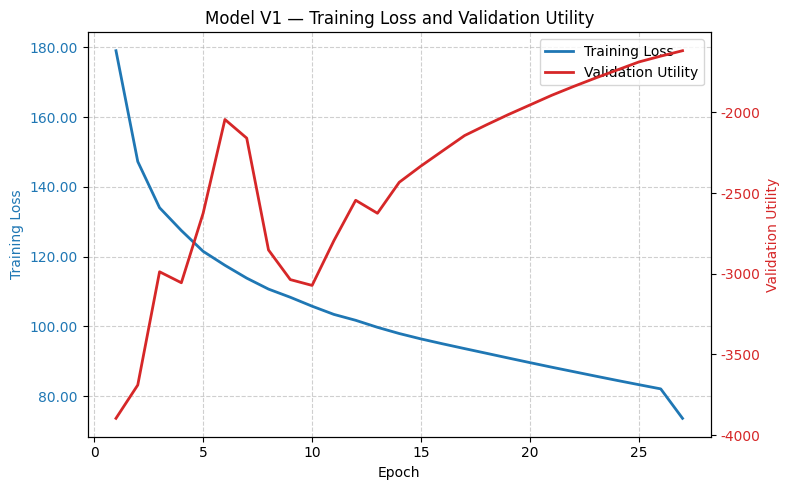

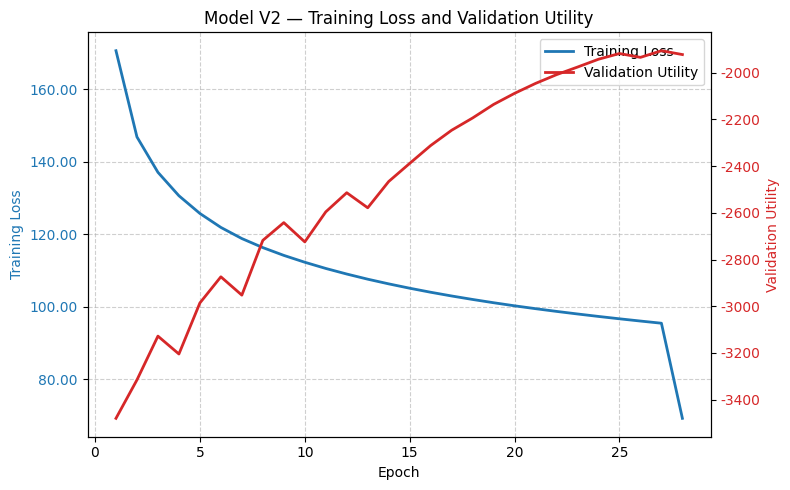

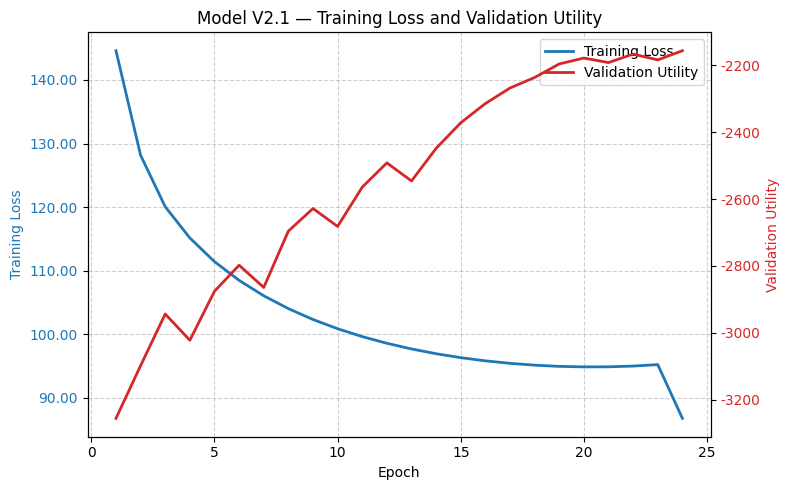

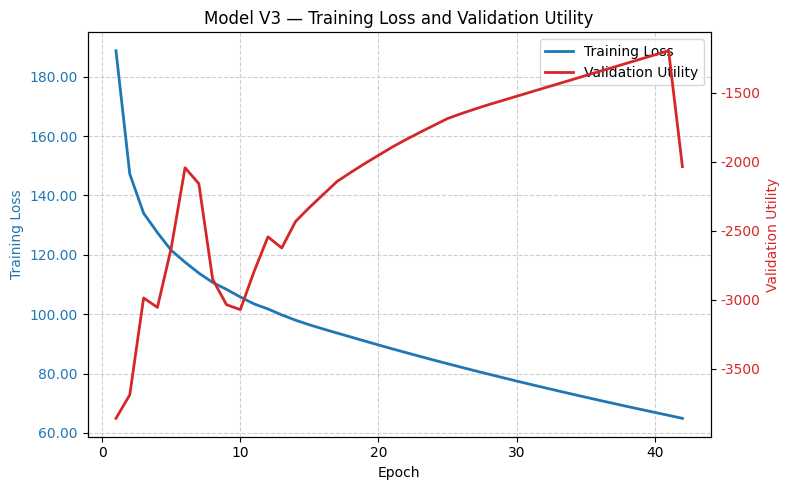

In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# ======================================================
# HARDCODED TRAINING LOGS (ORDER PRESERVED, NO SORTING)
# ======================================================

training_logs = {
    "Model V1": {
        "epoch": list(range(1, 28)),
        "train_loss": [
            179.00,147.24,134.02,127.48,121.52,117.52,113.84,
            110.70,108.36,105.80,103.45,101.76,99.75,97.97,
            96.42,95.01,93.65,92.31,90.96,89.63,88.32,87.05,
            85.78,84.53,83.31,82.11,73.67
        ],
        "val_utility": [
            -3896.00,-3689.50,-2988.00,-3056.00,-2625.50,-2044.50,
            -2160.00,-2853.00,-3036.50,-3072.50,-2795.50,-2545.00,
            -2625.50,-2433.50,-2332.50,-2238.00,-2144.00,-2078.00,
            -2014.50,-1954.50,-1894.50,-1840.00,-1788.00,-1738.00,
            -1688.00,-1652.00,-1618.50
        ],
    },

    "Model V2": {
        "epoch": list(range(1, 29)),
        "train_loss": [
            170.56,146.79,137.04,130.58,125.70,121.85,118.78,
            116.29,114.14,112.25,110.54,109.00,107.58,106.29,
            105.09,103.98,102.95,101.99,101.09,100.24,99.45,
            98.70,97.99,97.31,96.66,96.04,95.44,69.22
        ],
        "val_utility": [
            -3480.00,-3315.50,-3128.00,-3204.50,-2986.00,-2874.00,
            -2952.50,-2718.00,-2642.00,-2724.50,-2596.00,-2514.00,
            -2578.50,-2466.00,-2388.50,-2312.00,-2246.50,-2194.00,
            -2136.00,-2088.50,-2046.00,-2008.50,-1976.00,-1942.50,
            -1918.00,-1934.50,-1906.00,-1922.50
        ],
    },

    "Model V2.1": {
        "epoch": list(range(1, 25)),
        "train_loss": [
            144.59,128.15,120.06,115.15,111.43,108.48,106.06,
            104.04,102.33,100.88,99.64,98.59,97.70,96.95,
            96.33,95.83,95.44,95.15,94.96,94.88,94.89,
            95.01,95.24,86.79
        ],
        "val_utility": [
            -3256.00,-3098.50,-2944.00,-3022.50,-2876.00,-2798.00,
            -2864.50,-2696.00,-2628.50,-2682.00,-2564.50,-2492.00,
            -2546.00,-2448.50,-2372.00,-2314.50,-2268.00,-2236.50,
            -2196.00,-2178.50,-2192.00,-2166.50,-2184.00,-2156.50
        ],
    },

    "Model V3": {
        "epoch": list(range(1, 43)),
        "train_loss": [
            188.78,147.24,134.02,127.48,121.52,117.52,113.84,
            110.70,108.36,105.80,103.45,101.76,99.75,97.97,
            96.42,95.01,93.65,92.31,90.96,89.63,88.32,87.05,
            85.78,84.53,83.31,82.11,80.92,79.76,78.61,77.47,
            76.35,75.25,74.16,73.08,72.02,70.97,69.94,68.91,
            67.90,66.90,65.91,64.90
        ],
        "val_utility": [
            -3860.00,-3689.50,-2988.00,-3056.00,-2625.50,-2044.50,
            -2160.00,-2853.00,-3036.50,-3072.50,-2795.50,-2545.00,
            -2625.50,-2433.50,-2332.50,-2238.00,-2144.00,-2078.00,
            -2014.50,-1954.50,-1894.50,-1840.00,-1788.00,-1738.00,
            -1688.00,-1652.00,-1618.50,-1586.50,-1556.50,-1526.50,
            -1496.50,-1466.50,-1436.50,-1406.50,-1376.50,-1346.50,
            -1316.50,-1286.50,-1256.50,-1226.50,-1196.50,-2036.00
        ],
    },
}


# ======================================================
# PLOTTING — DUAL Y-AXIS, COLORED, READABLE
# ======================================================

for model_name, data in training_logs.items():
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # ---- Left Y-axis: Training Loss (BLUE) ----
    ax1.plot(
        data["epoch"],
        data["train_loss"],
        color="tab:blue",
        label="Training Loss",
        linewidth=2
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Training Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Format training loss ticks (2 decimals)
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

    # ---- Right Y-axis: Validation Utility (RED) ----
    ax2 = ax1.twinx()
    ax2.plot(
        data["epoch"],
        data["val_utility"],
        color="tab:red",
        label="Validation Utility",
        linewidth=2
    )
    ax2.set_ylabel("Validation Utility", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Format validation utility ticks (integer-like but keep decimals if needed)
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

    # ---- Title ----
    plt.title(f"{model_name} — Training Loss and Validation Utility")

    # ---- Combined Legend ----
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    # ---- Grid & Layout ----
    ax1.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()